In [1]:
# alyssa ang 211082M
# big data assignment - consolidated notebook

In [2]:
# Main
# Import libraries, Initialize pyspark, pandas and other visualization libraries

In [78]:
# Most of the insights are written in the pyspark portion,
# pandas was mainly used for visualizations, and comparisons

# Exploratory Data Analysis

In [122]:
# Objective
# To explore the data and provide findings and build a ML model to predict the salary

In [1]:
# Get files from drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Install required packages
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark
!pip install -q findspark

# Download and extract Spark
!wget -q https://downloads.apache.org/spark/spark-3.4.3/spark-3.4.3-bin-hadoop3-scala2.13.tgz
!tar xf spark-3.4.3-bin-hadoop3-scala2.13.tgz

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.3-bin-hadoop3-scala2.13"

# Initialize findspark and pyspark
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.config("spark.master", 'local').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [10]:
# Import the necessary libraries for pandas workflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy import stats
import seaborn.objects as so
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# dir to google drive file containing relevant datasets
dir = "/content/drive/MyDrive/BIGDATA_DATA/"

In [4]:
# Timer to compare between execution times between pyspark and pandas
import time
def timer():
    end_time = time.time()
    elapsed_time = end_time - start_time
    print()
    print(f"Elapsed {elapsed_time:.2f} seconds")
    return elapsed_time

Create spark dataframes using inferSchema option to get Spark to guess and automatically choose the most suitable schema of the input data, else, the default of the schemas is string for given datasets

In [5]:
# Create spark df for train_df and train_salary_df
train_df = spark.read.option('header', 'true').option('inferSchema', 'true').csv(dir+'train_dataset.csv')
train_df.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobRole: string (nullable = true)
 |-- education: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- distanceFromCBD: integer (nullable = true)



In [6]:
train_salaries_df = spark.read.option('header', 'true').option('inferSchema', 'true').csv(dir+'train_salaries.csv')
train_salaries_df.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salaryInThousands: integer (nullable = true)



In [23]:
# For easier reference to the datafranes
df_lists = {'train': train_df,
            'salaries': train_salaries_df}

Create pandas dataframes

In [13]:
# Read files with pd.read_csv
pd_train_df = pd.read_csv(dir+"train_dataset.csv")
pd_train_salaries_df = pd.read_csv(dir+"train_salaries.csv")

In [22]:
# For easier reference to the datafranes
pd_df_lists = {'train': pd_train_df,
               'salaries': pd_train_salaries_df}

Look at the overall shape, summary, and find out if there is any missing, errorenous, or duplicates wiithin data

# Initial Data Understanding
* Crucial step in uncovering potential issues, and a general understanding before further discovery

#### with pyspark

In [19]:
# Look at the top five rows of each given pyspark dataframe
test_df.show(5)
test_df.explain()

+----------------+---------+-------+-----------+-------+--------+---------------+---------------+
|           jobId|companyId|jobType|     degree|  major|industry|yearsExperience|distanceFromCBD|
+----------------+---------+-------+-----------+-------+--------+---------------+---------------+
|JOB1362685407687|   COMP33|MANAGER|HIGH_SCHOOL|   NONE|  HEALTH|             22|             73|
|JOB1362685407688|   COMP13| JUNIOR|       NONE|   NONE|    AUTO|             20|             47|
|JOB1362685407689|   COMP10|    CTO|    MASTERS|BIOLOGY|  HEALTH|             17|              9|
|JOB1362685407690|   COMP21|MANAGER|HIGH_SCHOOL|   NONE|     OIL|             14|             96|
|JOB1362685407691|   COMP36| JUNIOR|   DOCTORAL|BIOLOGY|     OIL|             10|             44|
+----------------+---------+-------+-----------+-------+--------+---------------+---------------+
only showing top 5 rows

== Physical Plan ==
FileScan csv [jobId#17,companyId#18,jobType#19,degree#20,major#21,industr

In [20]:
train_salaries_df.show(5)
train_salaries_df.explain()

+----------------+-----------------+
|           jobId|salaryInThousands|
+----------------+-----------------+
|JOB1362684407687|              130|
|JOB1362684407688|              101|
|JOB1362684407689|              137|
|JOB1362684407690|              142|
|JOB1362684407691|              163|
+----------------+-----------------+
only showing top 5 rows

== Physical Plan ==
FileScan csv [jobId#83,salaryInThousands#84] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/drive/MyDrive/BIGDATA_DATA/train_salaries.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<jobId:string,salaryInThousands:int>




In [24]:
# Look at the shapes of each dataframe
start_time = time.time()
for name, df in df_lists.items():
    num_rows = df.count()
    num_cols = len(df.columns)
    description = df.describe()
    print(f"{name}\nshape: ({num_rows}, {num_cols})")
    description.show()
elapsed_time = timer()

train
shape: (1000000, 8)
+-------+----------------+---------+--------------+---------+-------+--------+-----------------+------------------+
|summary|           jobId|companyId|       jobRole|education|  major|industry|  yearsExperience|   distanceFromCBD|
+-------+----------------+---------+--------------+---------+-------+--------+-----------------+------------------+
|  count|         1000000|  1000000|       1000000|  1000000|1000000| 1000000|          1000000|           1000000|
|   mean|            null|     null|          null|     null|   null|    null|        11.992386|          49.52926|
| stddev|            null|     null|          null|     null|   null|    null|7.212390868885656|28.877732628720008|
|    min|JOB1362684407687|    COMP0|           CEO|BACHELORS|BIOLOGY|    AUTO|                0|                 0|
|    max|JOB1362685407686|    COMP9|VICE_PRESIDENT|     NONE|PHYSICS|     WEB|               24|                99|
+-------+----------------+---------+----------


* Each shape of each dataframe is 1000000, meaning there is no missing data across dataframes
* Min salaryInThousands is zero -> erroreous, or actually paid that low?
* The rest of data seem generally okay, yearsExperience and distanceFromCBD can be 0 as some people may be just starting out their careers or live within CBD
* std for yearsExperience is 7.212 meaning a moderate spread in experience
* std for distanceFromCBD is 28.877 meaning a wide variability in distances

In [25]:
# Import library for countDistinct for easier retrieval of distinct values
from pyspark.sql.functions import countDistinct, sum, col as spark_col
start_time = time.time()
# Check for duplicated, and null data
for name, df in df_lists.items():
  print(f"{name}")
  # Check for null values
  num_null = df.select([sum(spark_col(c).isNull().cast("int")).alias(c) for c in df.columns])
  # Collect the results
  null_counts = num_null.first()
  null_results = {df.columns[i]: null_counts[i] for i in range(len(df.columns))}
  print("Null values =", null_results)
  # Check for duplicated data
  num_duplicated = df.count() - df.distinct().count()
  print(f"duplicated values = {num_duplicated}")
  # Print the total distinct counts of each col of dataframe
  print()
  print(f"distinct counts of each col of {name}")
  distinct_counts = df.agg(*(countDistinct(col).alias(col) for col in df.columns))
  distinct_counts.show()
elapsed_time = timer()

train
Null values = {'jobId': 0, 'companyId': 0, 'jobRole': 0, 'education': 0, 'major': 0, 'industry': 0, 'yearsExperience': 0, 'distanceFromCBD': 0}
duplicated values = 0

distinct counts of each col of train
+-------+---------+-------+---------+-----+--------+---------------+---------------+
|  jobId|companyId|jobRole|education|major|industry|yearsExperience|distanceFromCBD|
+-------+---------+-------+---------+-----+--------+---------------+---------------+
|1000000|       63|      8|        5|    9|       7|             25|            100|
+-------+---------+-------+---------+-----+--------+---------------+---------------+

salaries
Null values = {'jobId': 0, 'salaryInThousands': 0}
duplicated values = 0

distinct counts of each col of salaries
+-------+-----------------+
|  jobId|salaryInThousands|
+-------+-----------------+
|1000000|              280|
+-------+-----------------+


Elapsed 32.33 seconds


Looks like across the datasets the data does not have any problems with wrong naming conventions, missing values or duplicates - however, could there be errors within specific columns of data?

In [26]:
start_time = time.time()
# Define a list of cols to check specifically
colList = ['companyId','jobRole','education','major','industry']
# Create a list to hold results
results = []
# Iterate over the specified columns
for col_name in colList:
    # Count distinct values for each col
    distinct_count = train_df.agg(countDistinct(col_name).alias("distinct_count")).first()[0]
    # Append results to the list
    results.append((col_name, distinct_count))
# Create a DataFrame from the results
results_df = spark.createDataFrame(results, ["Column", "Distinct_Count"])
results_df.show()

for col in colList:
  distinct_job_roles = train_df.select(col).distinct().rdd.flatMap(lambda x: x).collect()
  print(f"distinct {col}")
  print(distinct_job_roles)
  print()
elapsed_time = timer()

+---------+--------------+
|   Column|Distinct_Count|
+---------+--------------+
|companyId|            63|
|  jobRole|             8|
|education|             5|
|    major|             9|
| industry|             7|
+---------+--------------+

distinct companyId
['COMP24', 'COMP52', 'COMP34', 'COMP33', 'COMP21', 'COMP30', 'COMP44', 'COMP9', 'COMP29', 'COMP20', 'COMP2', 'COMP5', 'COMP18', 'COMP62', 'COMP56', 'COMP55', 'COMP6', 'COMP51', 'COMP39', 'COMP28', 'COMP50', 'COMP26', 'COMP36', 'COMP14', 'COMP0', 'COMP41', 'COMP13', 'COMP59', 'COMP37', 'COMP32', 'COMP4', 'COMP47', 'COMP17', 'COMP48', 'COMP43', 'COMP35', 'COMP42', 'COMP45', 'COMP7', 'COMP25', 'COMP12', 'COMP11', 'COMP8', 'COMP60', 'COMP15', 'COMP58', 'COMP23', 'COMP38', 'COMP27', 'COMP49', 'COMP40', 'COMP57', 'COMP31', 'COMP46', 'COMP22', 'COMP19', 'COMP54', 'COMP10', 'COMP16', 'COMP53', 'COMP3', 'COMP1', 'COMP61']

distinct jobRole
['CTO', 'JUNIOR', 'JANITOR', 'CFO', 'CEO', 'MANAGER', 'VICE_PRESIDENT', 'SENIOR']

distinct educat

There are 63 unique companies, 8 different jobRoles, 5 different education types, 9 different majors, and 7 different industries
* A good spread of diverse attributes
* Considered a small amount of columns, making it easier to perform analysis and derive insights without overwhelming complexity

#### with pandas
portion is similar to pyspark

In [27]:
# Print the first five rows of each df
for name, df in pd_df_lists.items():
  print(f"{name}\n{df.head(5)}")
  print()

train
              jobId companyId         jobRole    education      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  distanceFromCBD  
0   HEALTH               10               83  
1      WEB                3               73  
2   HEALTH               10               38  
3     AUTO                8               17  
4  FINANCE                8               16  

salaries
              jobId  salaryInThousands
0  JOB1362684407687                130
1  JOB1362684407688                101
2  JOB1362684407689                137
3  JOB1362684407690                142
4  JOB1362684407691                163



In [29]:
# Print the shape of each dataframe, and provide a description
for name, df in pd_df_lists.items():
  print(f"{name}")
  print(f"shape = {df.shape}\n{df.describe()}")
  print()

train
shape = (1000000, 8)
       yearsExperience  distanceFromCBD
count   1000000.000000   1000000.000000
mean         11.992386        49.529260
std           7.212391        28.877733
min           0.000000         0.000000
25%           6.000000        25.000000
50%          12.000000        50.000000
75%          18.000000        75.000000
max          24.000000        99.000000

salaries
shape = (1000000, 2)
       salaryInThousands
count     1000000.000000
mean          116.061818
std            38.717936
min             0.000000
25%            88.000000
50%           114.000000
75%           141.000000
max           301.000000



In [30]:
# Check for any missing values in dataset
def checkNull(df):
    print(f"null values = \n{df.isnull().sum()}")

# Check for any duplicated values in dataset
def checkDuplicates(df):
    print(f"duplicates = {df.duplicated().sum()}")

# Check for null, duplicated values and print nunique for each col
for name, df in pd_df_lists.items():
  print(name)
  checkNull(df)
  checkDuplicates(df)
  # Print the nunique count of each col
  print("nunique counts =")
  print({col: df[col].nunique() for col in df.columns})
  print()

train
null values = 
jobId              0
companyId          0
jobRole            0
education          0
major              0
industry           0
yearsExperience    0
distanceFromCBD    0
dtype: int64
duplicates = 0
nunique counts =
{'jobId': 1000000, 'companyId': 63, 'jobRole': 8, 'education': 5, 'major': 9, 'industry': 7, 'yearsExperience': 25, 'distanceFromCBD': 100}

salaries
null values = 
jobId                0
salaryInThousands    0
dtype: int64
duplicates = 0
nunique counts =
{'jobId': 1000000, 'salaryInThousands': 280}



In [31]:
# Define a list of cols to check specifically
colList = ['jobRole','education','major','industry']
nunique = {col: pd_train_df[col].nunique() for col in colList}
# Put into a df for easier referencing in a table format
nunique_df = pd.DataFrame(list(nunique.items()), columns=['Column', 'nUnique_Count'])
print(nunique_df)
print()
# Print unique values of each col
for col in colList:
    print(f"{col}{pd_train_df[col].unique()}\n")

      Column  nUnique_Count
0    jobRole              8
1  education              5
2      major              9
3   industry              7

jobRole['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']

education['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']

major['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']

industry['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']



# Data Cleaning
As explored from the above portion, there are salaries that are 0
* These values will be imputed with the median salaries of the respective jobRole

#### with pyspark

In [7]:
# Merge with salaries for the full dataset
employee_data = train_df.join(train_salaries_df, on='jobId', how='left')
# Show the merged DataFrame
employee_data.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+---------------+-----------------+
|           jobId|companyId|       jobRole|  education|    major|industry|yearsExperience|distanceFromCBD|salaryInThousands|
+----------------+---------+--------------+-----------+---------+--------+---------------+---------------+-----------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|             83|              130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|             73|              101|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|             38|              137|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|             17|              142|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|             16|              163|


In [8]:
# Push to SQL
employee_data.createOrReplaceTempView("employees")

statement = """
SELECT jobRole,
       ROUND(MEDIAN(salaryInThousands), 2) AS median_salary,
       ROUND(MIN(salaryInThousands), 2) AS min_salary,
       ROUND(MAX(salaryInThousands), 2) AS max_salary
FROM employees
GROUP BY jobRole
ORDER BY median_salary DESC
"""
# Show the results
spark.sql(statement).show()

+--------------+-------------+----------+----------+
|       jobRole|median_salary|min_salary|max_salary|
+--------------+-------------+----------+----------+
|           CEO|        142.0|        55|       298|
|           CTO|        132.0|         0|       301|
|           CFO|        132.0|        51|       301|
|VICE_PRESIDENT|        122.0|         0|       272|
|       MANAGER|        112.0|         0|       270|
|        SENIOR|        102.0|        31|       258|
|        JUNIOR|         92.0|         0|       248|
|       JANITOR|         68.0|        17|       189|
+--------------+-------------+----------+----------+



In [9]:
# Look at which jobs are getting paid  0 for their salaries
start_time = time.time()
employee_data.filter(employee_data.salaryInThousands == 0).show()
timer()

+----------------+---------+--------------+-----------+-----------+--------+---------------+---------------+-----------------+
|           jobId|companyId|       jobRole|  education|      major|industry|yearsExperience|distanceFromCBD|salaryInThousands|
+----------------+---------+--------------+-----------+-----------+--------+---------------+---------------+-----------------+
|JOB1362684438246|   COMP44|        JUNIOR|   DOCTORAL|       MATH|    AUTO|             11|              7|                0|
|JOB1362684903671|   COMP34|        JUNIOR|       NONE|       NONE|     OIL|              1|             25|                0|
|JOB1362685059763|   COMP25|           CTO|HIGH_SCHOOL|       NONE|    AUTO|              6|             60|                0|
|JOB1362685223816|   COMP42|       MANAGER|   DOCTORAL|ENGINEERING| FINANCE|             18|              6|                0|
|JOB1362685235843|   COMP40|VICE_PRESIDENT|    MASTERS|ENGINEERING|     WEB|              3|             29|   

8.534314155578613

In [40]:
start_time = time.time()
# Fill the missing 0 salaries with median salaries
from pyspark.sql.functions import when, lit

# Calculate median salary
median_salary = employee_data.approxQuantile("salaryInThousands", [0.5], 0.01)[0]

# Fill missing salaries with median salary
employee_data = employee_data.withColumn("salaryInThousands",
                                         when(spark_col("salaryInThousands") == 0,
                                              lit(median_salary))  # Use lit to assign new values
                                         .otherwise(spark_col("salaryInThousands")))

# Reiterate and look at which jobs are getting paid  0 for their salaries
employee_data.filter(employee_data.salaryInThousands == 0).show()
timer()

+-----+---------+-------+---------+-----+--------+---------------+---------------+-----------------+
|jobId|companyId|jobRole|education|major|industry|yearsExperience|distanceFromCBD|salaryInThousands|
+-----+---------+-------+---------+-----+--------+---------------+---------------+-----------------+
+-----+---------+-------+---------+-----+--------+---------------+---------------+-----------------+


Elapsed 13.49 seconds


13.485330581665039

#### with pandas

In [42]:
# Merge the dataframes
pandas_df = pd.merge(pd_train_df, pd_train_salaries_df, on='jobId', how='left')

In [43]:
# Look for the salaryInThousands that is =0
pandas_df[pandas_df["salaryInThousands"]==0]

,jobId,companyId,jobRole,education,major,industry,yearsExperience,distanceFromCBD,salaryInThousands
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [44]:
# Get the median salaries for the respective jobRole
start_time = time.time()
median_salaries_by_job_role = pandas_df.groupby('jobRole')['salaryInThousands'].median().reset_index()
median_salaries_by_job_role.columns = ['jobRole', 'medianSalary']
pandas_df = pd.merge(pandas_df, median_salaries_by_job_role, on='jobRole', how='left')
pandas_df['salaryInThousands'] = pandas_df.apply(
    lambda row: row['medianSalary'] if row['salaryInThousands'] == 0 else row['salaryInThousands'],
    axis=1)
pandas_df = pandas_df.drop(columns=['medianSalary'])
print(pandas_df[pandas_df["salaryInThousands"]==0])
timer()

Empty DataFrame
Columns: [jobId, companyId, jobRole, education, major, industry, yearsExperience, distanceFromCBD, salaryInThousands]
Index: []

Elapsed 10.95 seconds


10.95434045791626

# Understanding overall distributions of data
* Getting a general understanding on the distributions of data gives a grasp on the general characteristics, and identify and flag trends for further analysis

#### with pyspark

In [45]:
# Push dataframe to pyspark SQL
_ = employee_data.createOrReplaceTempView('employees')

##### Distribution of salaries, jobRoles, industries, education, majors, distanceFromCBD, and companies

Distribution of salaries

In [47]:
# Look at the distribution of salaries after imputation
statement = """
SELECT jobRole,
       MEDIAN(salaryInThousands) AS median_salary,
       ROUND(MIN(salaryInThousands), 2) AS min_salary,
       ROUND(MAX(salaryInThousands), 2) AS max_salary
FROM employees
GROUP BY jobRole
ORDER BY median_salary DESC
"""
# Show the results
spark.sql(statement).show()

+--------------+-------------+----------+----------+
|       jobRole|median_salary|min_salary|max_salary|
+--------------+-------------+----------+----------+
|           CEO|        142.0|      55.0|     298.0|
|           CTO|        132.0|      51.0|     301.0|
|           CFO|        132.0|      51.0|     301.0|
|VICE_PRESIDENT|        122.0|      44.0|     272.0|
|       MANAGER|        112.0|      37.0|     270.0|
|        SENIOR|        102.0|      31.0|     258.0|
|        JUNIOR|         92.0|      23.0|     248.0|
|       JANITOR|         68.0|      17.0|     189.0|
+--------------+-------------+----------+----------+



By imputing the zero salaryinThousands, results in a more comprehensive view of the min and median of salary for each jobRole
* The highest min and median salary is CEO - as the CEO is the highest ranking role in terms of organizational structure
* The lowest min, median and max salary is JANITOR
* CTO, and CFO are lower in min, and median salary, however have the highest max salary - could it be due to other factors contributing to the discrepancy?

In [48]:
# CEO should have the highest salary, however CTO and CFO has highest
statement = """
SELECT *
FROM employees
WHERE salaryInThousands = 301
"""
# Show the results
spark.sql(statement).show()

+----------------+---------+-------+---------+-----------+--------+---------------+---------------+-----------------+
|           jobId|companyId|jobRole|education|      major|industry|yearsExperience|distanceFromCBD|salaryInThousands|
+----------------+---------+-------+---------+-----------+--------+---------------+---------------+-----------------+
|JOB1362684808298|   COMP45|    CFO| DOCTORAL|ENGINEERING|     OIL|             23|              3|            301.0|
|JOB1362685093249|   COMP47|    CTO|  MASTERS|ENGINEERING|     OIL|             24|              0|            301.0|
+----------------+---------+-------+---------+-----------+--------+---------------+---------------+-----------------+



* Though CFO amd CTO are below CEO in organizational hierachy, two people were the highest paid amongst all the other jobRoles
* Despite the hierarchical structure within the organization, two people with jobRoles of CFO and CTO were among the highest-paid, surpassing CEO in terms of salary - this could be due to other factors that affect the pay
* Both majored in ENGINEERING, live within the CBD, and have the highest years of experience, and have pursued higher education

In [49]:
statement = """
SELECT *
FROM employees
WHERE salaryInThousands < 301
ORDER BY salaryInThousands DESC
"""
# Show the results
spark.sql(statement).show(10)

+----------------+---------+-------+---------+-----------+--------+---------------+---------------+-----------------+
|           jobId|companyId|jobRole|education|      major|industry|yearsExperience|distanceFromCBD|salaryInThousands|
+----------------+---------+-------+---------+-----------+--------+---------------+---------------+-----------------+
|JOB1362684980464|   COMP60|    CEO|  MASTERS|ENGINEERING|     OIL|             22|              1|            298.0|
|JOB1362685319434|    COMP3|    CEO|BACHELORS|   BUSINESS| FINANCE|             24|             28|            294.0|
|JOB1362684700908|   COMP44|    CEO| DOCTORAL|ENGINEERING|     OIL|             19|             18|            294.0|
|JOB1362685313400|   COMP35|    CEO| DOCTORAL|   BUSINESS| FINANCE|             16|             17|            293.0|
|JOB1362684911649|    COMP3|    CEO| DOCTORAL|    PHYSICS|     OIL|             24|              1|            293.0|
|JOB1362684454890|   COMP18|    CEO|BACHELORS|   BUSINES

Down the line of highest earning persons,
* Majority of people are CE0s and some CTOs, and CFOs, which reflects the hierarchical structure, and corresponding salaries
* All pursued higher education, majoring in mostly ENGINEERING and BUSINESS, have higher yearsExperience, and live within CBD

Likely that yearsExperience, education, major and distanceFromCBD have high correlation with salaryInThousands

Distribution of jobRoles

In [50]:
# Show the distribution of each jobRole
statement = """
WITH total_count AS (
    SELECT COUNT(*) AS total
    FROM employees
  )
SELECT *
FROM(
  SELECT jobRole,
    COUNT(*) AS job_count,
    ROUND((COUNT(*) * 100.0 / total_count.total),2) AS percentage
  FROM employees, total_count
  GROUP BY jobRole, total_count.total
  )
ORDER BY job_count DESC
"""
# Show the results
spark.sql(statement).show()

+--------------+---------+----------+
|       jobRole|job_count|percentage|
+--------------+---------+----------+
|        SENIOR|   125886|     12.59|
|VICE_PRESIDENT|   125235|     12.52|
|       MANAGER|   125121|     12.51|
|           CTO|   125046|     12.50|
|       JANITOR|   124971|     12.50|
|           CEO|   124778|     12.48|
|        JUNIOR|   124594|     12.46|
|           CFO|   124369|     12.44|
+--------------+---------+----------+



Can be seen that the distribution of jobRoles are fairly distributed between role, and that senior is the highest at 12.59% and CFO being the lowest at 12.44%

Distribution of industries

In [53]:
# Show the distribution of each industry
statement = """
WITH total_count AS (
    SELECT COUNT(*) AS total
    FROM employees
  )
SELECT *
FROM(
  SELECT industry,
    COUNT(*) AS industry_count,
    ROUND((COUNT(*) * 100.0 / total_count.total),2) AS percentage
  FROM employees, total_count
  GROUP BY industry, total_count.total
  )
ORDER BY industry_count DESC
"""
# Show the results
spark.sql(statement).show()

+---------+--------------+----------+
| industry|industry_count|percentage|
+---------+--------------+----------+
|      WEB|        143206|     14.32|
|     AUTO|        142943|     14.29|
|  FINANCE|        142867|     14.29|
|EDUCATION|        142819|     14.28|
|      OIL|        142771|     14.28|
|   HEALTH|        142755|     14.28|
|  SERVICE|        142639|     14.26|
+---------+--------------+----------+



Similar to jobRoles, there is a well distributed distribution, with WEB being the highest 14.32% and SERVICE being the lowest 14.26%

Distribution of education

In [51]:
# Show the distribution of each education
statement = """
WITH total_count AS (
    SELECT COUNT(*) AS total
    FROM employees
  )
SELECT *
FROM(
  SELECT education,
    COUNT(*) AS education_count,
    ROUND((COUNT(*) * 100.0 / total_count.total),2) AS percentage
  FROM employees, total_count
  GROUP BY education, total_count.total
  )
ORDER BY education_count DESC
"""
# Show the results
spark.sql(statement).show()

+-----------+---------------+----------+
|  education|education_count|percentage|
+-----------+---------------+----------+
|HIGH_SCHOOL|         236976|     23.70|
|       NONE|         236854|     23.69|
|  BACHELORS|         175495|     17.55|
|   DOCTORAL|         175364|     17.54|
|    MASTERS|         175311|     17.53|
+-----------+---------------+----------+



Majority of people have HIGH_SCHOOL 23.7% or NONE 23.69% education, followed by BACHELORS 17.55%. There is not much variance between different level of majors. Lowest being MASTERS

Distribution of majors

In [52]:
# Show the distribution of each major
statement = """
WITH total_count AS (
    SELECT COUNT(*) AS total
    FROM employees
  )
SELECT *
FROM(
  SELECT major,
    COUNT(*) AS major_count,
    ROUND((COUNT(*) * 100.0 / total_count.total),2) AS percentage
  FROM employees, total_count
  GROUP BY major, total_count.total
  )
ORDER BY major_count DESC
"""
# Show the results
spark.sql(statement).show()

+-----------+-----------+----------+
|      major|major_count|percentage|
+-----------+-----------+----------+
|       NONE|     532355|     53.24|
|  CHEMISTRY|      58875|      5.89|
| LITERATURE|      58684|      5.87|
|ENGINEERING|      58596|      5.86|
|   BUSINESS|      58518|      5.85|
|    PHYSICS|      58410|      5.84|
|    COMPSCI|      58382|      5.84|
|    BIOLOGY|      58379|      5.84|
|       MATH|      57801|      5.78|
+-----------+-----------+----------+



As reflected in education, NONE 53.24% major makes up for majority of the distribution. Followed by CHEMISTY 5.89% and the lowest major being MATH 5.78%

Distribution of distanceFromCBD

In [54]:
# Show the summary of distances
statement = """
SELECT ROUND(MIN(distanceFromCBD), 2) AS min_distance,
  ROUND(MAX(distanceFromCBD), 2) AS max_distance,
  ROUND(AVG(distanceFromCBD), 2) AS avg_distance,
  ROUND(STDDEV(distanceFromCBD), 2) AS stddev_distance
FROM employees
"""
# Show the results
spark.sql(statement).show()

+------------+------------+------------+---------------+
|min_distance|max_distance|avg_distance|stddev_distance|
+------------+------------+------------+---------------+
|           0|          99|       49.53|          28.88|
+------------+------------+------------+---------------+



* The minimum distance for people living from the CBD is 0 - they live directly within the CBD, and the furthest distance is 99km
* Std deviation of 28.88 signifies a significant variation in the distances employees live from the CBD
* On avg, people live 49.53km away from CBD

In [55]:
statement = """
WITH distance AS (
  SELECT ROUND(MIN(distanceFromCBD), 2) AS min_distance,
    ROUND(MAX(distanceFromCBD), 2) AS max_distance,
    ROUND(AVG(distanceFromCBD), 2) AS avg_distance
  FROM employees
),
total_count AS (
  SELECT COUNT(*) AS total_counts
  FROM employees
),
employee_distance AS (
  SELECT
    CASE
      WHEN distanceFromCBD = (SELECT min_distance FROM distance) THEN 'min_distance'
      WHEN distanceFromCBD = (SELECT max_distance FROM distance) THEN 'max_distance'
      WHEN distanceFromCBD < (SELECT avg_distance FROM distance) THEN '< avg_distance'
      ELSE '> avg_distance'
    END AS distanceRange,
    COUNT(*) AS employee_count
  FROM employees
  GROUP BY
    CASE
      WHEN distanceFromCBD = (SELECT min_distance FROM distance) THEN 'min_distance'
      WHEN distanceFromCBD = (SELECT max_distance FROM distance) THEN 'max_distance'
      WHEN distanceFromCBD < (SELECT avg_distance FROM distance) THEN '< avg_distance'
      ELSE '> avg_distance'
    END
),
median_salaries AS (
  SELECT
    CASE
      WHEN distanceFromCBD = (SELECT min_distance FROM distance) THEN 'min_distance'
      WHEN distanceFromCBD = (SELECT max_distance FROM distance) THEN 'max_distance'
      WHEN distanceFromCBD < (SELECT avg_distance FROM distance) THEN '< avg_distance'
      ELSE '> avg_distance'
    END AS distanceRange,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY salaryInThousands) AS median_salary
  FROM employees
  GROUP BY
    CASE
      WHEN distanceFromCBD = (SELECT min_distance FROM distance) THEN 'min_distance'
      WHEN distanceFromCBD = (SELECT max_distance FROM distance) THEN 'max_distance'
      WHEN distanceFromCBD < (SELECT avg_distance FROM distance) THEN '< avg_distance'
      ELSE '> avg_distance'
    END
)
SELECT ed.distanceRange, ms.median_salary, ed.employee_count,
  ROUND((ed.employee_count * 100.0 / tc.total_counts), 2) AS percentage
FROM employee_distance ed
JOIN total_count tc
JOIN median_salaries ms
  ON ed.distanceRange = ms.distanceRange
ORDER BY ms.median_salary DESC
"""
# Show the results
spark.sql(statement).show()

+--------------+-------------+--------------+----------+
| distanceRange|median_salary|employee_count|percentage|
+--------------+-------------+--------------+----------+
|  min_distance|        134.0|         10123|      1.01|
|< avg_distance|        124.0|        489322|     48.93|
|> avg_distance|        105.0|        490375|     49.04|
|  max_distance|         95.0|         10180|      1.02|
+--------------+-------------+--------------+----------+



Slightly more people live further from CBD (49.04%)
* People who live within or less than avg distance from CBD are more likely to earn more
* Could be due to better job opportunities, higher-paying roles, or more higher paying industries being located closer to the CBD
* People who live further from the CBD are more likely to earn less



Distribution of companies

In [70]:
# Look at the distribution of people in each company
statement = """
WITH company_counts AS (
    SELECT companyId,
           COUNT(*) AS num_employees
    FROM employees
    GROUP BY companyId
),
total_counts AS (
    SELECT SUM(num_employees) AS total_employees
    FROM company_counts
)
SELECT cc.companyId,
       cc.num_employees,
       ROUND((cc.num_employees / tc.total_employees) * 100, 2) AS percentage
FROM company_counts cc, total_counts tc
ORDER BY cc.num_employees DESC
"""
# Show the results
spark.sql(statement).show(10)

+---------+-------------+----------+
|companyId|num_employees|percentage|
+---------+-------------+----------+
|   COMP39|        16193|      1.62|
|   COMP35|        16114|      1.61|
|   COMP59|        16066|      1.61|
|   COMP30|        16041|       1.6|
|    COMP3|        16028|       1.6|
|   COMP40|        16008|       1.6|
|   COMP44|        16005|       1.6|
|   COMP51|        16005|       1.6|
|    COMP9|        15988|       1.6|
|   COMP56|        15979|       1.6|
+---------+-------------+----------+
only showing top 10 rows



In [71]:
# Look at the distribution of people in each company
statement = """
WITH company_counts AS (
    SELECT companyId,
           COUNT(*) AS num_employees
    FROM employees
    GROUP BY companyId
),
total_counts AS (
    SELECT SUM(num_employees) AS total_employees
    FROM company_counts
)
SELECT cc.companyId,
       cc.num_employees,
       ROUND((cc.num_employees / tc.total_employees) * 100, 2) AS percentage
FROM company_counts cc, total_counts tc
ORDER BY cc.num_employees ASC
"""
# Show the results
spark.sql(statement).show(10)

+---------+-------------+----------+
|companyId|num_employees|percentage|
+---------+-------------+----------+
|   COMP57|        15635|      1.56|
|    COMP8|        15638|      1.56|
|    COMP2|        15641|      1.56|
|    COMP0|        15666|      1.57|
|   COMP17|        15715|      1.57|
|   COMP52|        15737|      1.57|
|   COMP26|        15750|      1.58|
|   COMP29|        15754|      1.58|
|   COMP31|        15756|      1.58|
|   COMP55|        15767|      1.58|
+---------+-------------+----------+
only showing top 10 rows



The distribution of companies is equally distributed

In [58]:
# Look at the top 10 highest paying companies
statement = """
SELECT companyId,
  ROUND(MIN(salaryInThousands), 2) AS min_salary,
  ROUND(MAX(salaryInThousands), 2) AS max_salary,
  ROUND(MEDIAN(salaryInThousands), 2) AS median_salary
FROM employees
GROUP BY companyId
ORDER BY median_salary DESC
"""
# Show the results
spark.sql(statement).show(10)

+---------+----------+----------+-------------+
|companyId|min_salary|max_salary|median_salary|
+---------+----------+----------+-------------+
|   COMP44|      20.0|     294.0|        115.0|
|   COMP60|      20.0|     298.0|        115.0|
|   COMP24|      21.0|     285.0|        114.0|
|   COMP34|      22.0|     272.0|        114.0|
|   COMP33|      22.0|     268.0|        114.0|
|   COMP52|      19.0|     271.0|        114.0|
|   COMP21|      20.0|     287.0|        114.0|
|   COMP30|      20.0|     282.0|        114.0|
|    COMP9|      20.0|     264.0|        114.0|
|   COMP29|      18.0|     284.0|        114.0|
+---------+----------+----------+-------------+
only showing top 10 rows



In [57]:
# Look at the top 10 lowest paying companies
statement = """
SELECT companyId,
  ROUND(MIN(salaryInThousands), 2) AS min_salary,
  ROUND(MAX(salaryInThousands), 2) AS max_salary,
  ROUND(MEDIAN(salaryInThousands), 2) AS median_salary
FROM employees
GROUP BY companyId
ORDER BY median_salary ASC
"""
# Show the results
spark.sql(statement).show(10)

+---------+----------+----------+-------------+
|companyId|min_salary|max_salary|median_salary|
+---------+----------+----------+-------------+
|   COMP28|      19.0|     273.0|        113.0|
|   COMP37|      20.0|     285.0|        113.0|
|   COMP35|      21.0|     293.0|        113.0|
|   COMP42|      19.0|     281.0|        113.0|
|   COMP45|      20.0|     301.0|        113.0|
|   COMP15|      21.0|     273.0|        113.0|
|   COMP31|      24.0|     283.0|        113.0|
|   COMP57|      19.0|     263.0|        113.0|
|   COMP19|      20.0|     273.0|        113.0|
|   COMP54|      22.0|     274.0|        113.0|
+---------+----------+----------+-------------+
only showing top 10 rows



Generally looking, between the salaries of companies do not have that much difference, however, could be a factor for other features such as jobRole as usually different companies pay differently



---


From this portion of understanding the datasets,
* The dataset is generally quite distributed, not many data points appearing at the tail or head
* However, majority of people in the dataset have NONE major (53.24%), and HIGH_SCHOOL (23.70%) or NONE (23.69%) education
* Most people are in the WEB industry, and have SENIOR jobRole

#### with pandas

majority of insights are written above in the pyspark portion

In [59]:
# Set theme for graphs
sns.set_theme(style="ticks", palette="pastel")

In [60]:
# Functions that return percentages
def calculate_univariate_percentages(df, x):
    # Calculate total counts for each unique value in column x
    totalCounts = df[x].value_counts().to_dict()
    # Calculate percentages
    total_rows = len(df)
    percentages = {k: f"{round((v / total_rows) * 100, 3):.3f}%"
                   for k, v in totalCounts.items()}
    return percentages

def calculate_pairwise_percentages(df, x, hue):
    # Calculate total counts for each unique value in x and hue
    counts = df.groupby([hue, x]).size().unstack(fill_value=0)

    # Calculate percentages for each category in hue (TypeName)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    return percentages

def calculate_count_percentages(df, x, col):
    # Calculate total counts (sum of all values in column x)
    totalCounts = df[x].sum()

    # Calculate percentages
    percentages = {row[col]: f"{(row[x] / totalCounts) * 100:.3f}%"
                   for index, row in df.iterrows()}

    return percentages
# Functions that deal with graphs and visualizations
def setTitleLabels(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

# Plots a table beside graph
def plotTable(ax, table_data):
    # Convert dictionary to a list of lists for Matplotlib table
    table_data_list = [[key, value] for key, value in table_data.items()]

    # Add the table to the plot and adjust size
    table = ax.table(cellText=table_data_list, loc='right', bbox=[1.1, 0.2, 0.99, 0.7])
    return table

# Plots histograms and annotates with counts accordingly
def plotHist(df, x, hue, title, xlabel, ylabel, table_data ,remove_legend=True):
    # Plot barplots
    plt.figure(figsize=(7, 4))
    ax = sns.histplot(data=df, x=x, hue=hue,
                      multiple="dodge", palette='Set2', label="legend")

    # Calculate values manually
    totalCounts = df[hue].value_counts().to_dict()

    # Annotate each bar
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # Only annotate bars with a height greater than 0
            ax.annotate(f'{height:.0f}',
                        xy=(patch.get_x() + patch.get_width() / 2, height),
                        xytext=(0, -3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, color='black', weight='bold')

    # Set the title and labels
    setTitleLabels(title, xlabel, ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a faint grid for readability
    ax.set_ylim(0, max(df[hue].value_counts()) + 3000)

    # Plot a table within the graph to show data
    plotTable(ax, table_data)
    if remove_legend:
        ax.legend().remove()
    plt.show()

# Plots BoxPlots
def plotBoxPlot(list_table, df, x, y, hue, title, xlabel, ylabel):
    # Create boxplot
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=df, x=x, y=y, hue=hue, width=0.5, palette='Set2', legend=False)
    if hue is not None:
        plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    if list_table is not None:
        plotTable(ax, list_table)
    # Add labels and title
    setTitleLabels(title, xlabel, ylabel)
    plt.show()

# Plots count cat plots
def plotBarPlot(table_data, col):
  order = pandas_df[col].value_counts().index
  total_count = pandas_df.shape[0]
  category_counts = pandas_df[col].value_counts()
  percentages = (category_counts / total_count * 100).reindex(order)

  fig, ax = plt.subplots(1, 1, figsize=(10, 4))
  sns.barplot(x=category_counts.index, y=category_counts.values,palette="pastel").grid(True)

  for p in ax.patches:
      height = p.get_height()
      category = p.get_x() + p.get_width() / 2
      category_label = order[int(category)]
      percentage = percentages[category_label]
      ax.annotate(f'{percentage:.3f}%', (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='center', xytext=(0, 5), textcoords='offset points')

  if table_data is not None:
    plotTable(ax, table_data)
  plt.xlabel(col)
  plt.title(f"Distribution of {col}")
  plt.show()

# Plot correlation map with specific datasets, and columns
def plotCorrMap(df, cols, title, ax):
    # Choose specific features to correlate
    corr = df[cols].corr(numeric_only=True)

    # Plot the correlation map
    plt.figure(figsize=(5,3))
    sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={"size": 10}, ax=ax)
    ax.set_title(f"Correlation Map {title}")

#### New insights
Insights that were not covered in the pyspark portion
  * Overall distribution of values
    * .explain() in the pyspark portion summarizes the spread and central tendencies of values, however, it is often hard to analyse such a large spread of statistical data in tabular format
    * Histogram provides a consolidated and easier reference in graphical format; enabling intuitive identification of patterns, outliers, and trends
  * Correlation for each jobRole
    * pyspark has .corr() however, it would be more intensive to plot for each correlation and relationship
    * Correlation map also provides a consolidated and easier reference in graphical format


Distribution of values

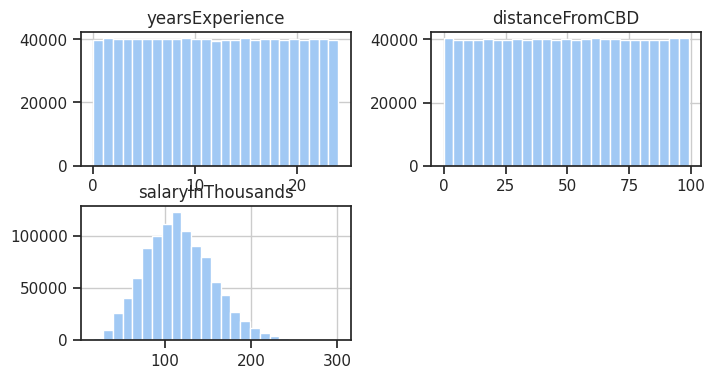

In [63]:
# Shows overall distibution of each column
pandas_df.hist(bins=25,figsize=(8,4)) # Plot histogram
plt.show()

From the graph,
* yearsExperience, and distanceFromCBD are more evenly distributed in their distribution of values, as compared to salaryInThousands
* The even distribution expresses that the data encompasses a wide range of years of experience, and distances
* salaryInThousands looks to be left skewed where more values are majority of the values are concentrated on the higher end, with fewer values on the lower end - this means that there is more variability in the salary
* Signifying presence of a number of significantly higher paid roles in comparison to significantly lower paid roles

Correlation map of each jobRole

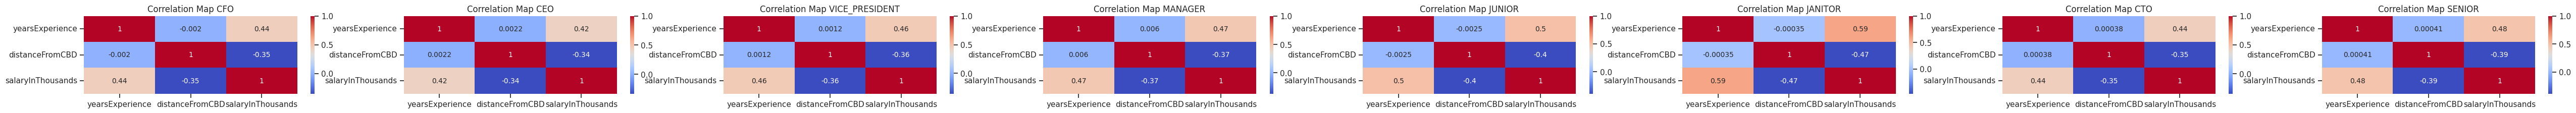

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

In [67]:
# Plot correlation map for each jobRole
jobRoles_list = pandas_df['jobRole'].unique()
jobRoles_dfs = {}
for jobRole in jobRoles_list:
    jobRoles_dfs[jobRole] = pandas_df[pandas_df['jobRole'] == jobRole]

num_job_roles = len(jobRoles_list)
fig, axs = plt.subplots(1, num_job_roles, figsize=(8*num_job_roles, 2))
if num_job_roles == 1:
    plotCorrMap(jobRoles_dfs[jobRoles_list[0]], jobRoles_dfs[jobRoles_list[0]].columns, jobRoles_list[0], axs)
else:
    for i in range(num_job_roles):
        plotCorrMap(jobRoles_dfs[jobRoles_list[i]], jobRoles_dfs[jobRoles_list[i]].columns, jobRoles_list[i], axs[i])

plt.tight_layout()
plt.show()

Organized correlation map by hierarchical structure for easier reference
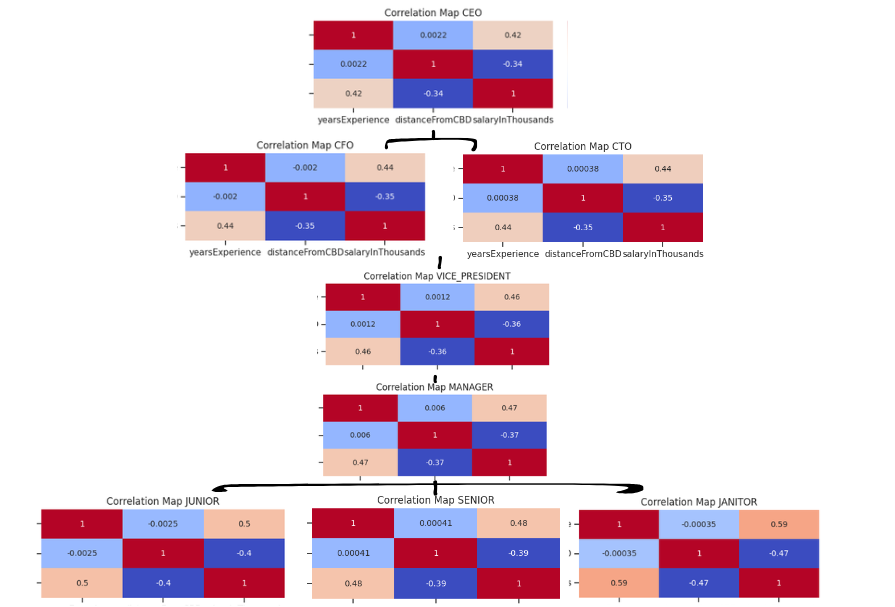

* Across all job roles, there is a consistent positive correlation between yearsExperience and salaryInThousands - indicating that more years of experience generally lead to higher salaries
* Consistent negative correlation between distanceFromCBD and salaryInThousands - indicating people living farther from CBD tend to have lower salaries
* Strength of correlations varies slightly between roles e.g. JANITOR salaries have strongest negative correlation with distanceFromCBD (-0.47) and strongest positive correlation with yearsExperience (0.59)

#### insights already covered in pyspark
* this portion is an exact copy of what was done in pyspark to reflect findings in graphs, and make comparison between tabular and graphical visualizations

Distribution of salaries

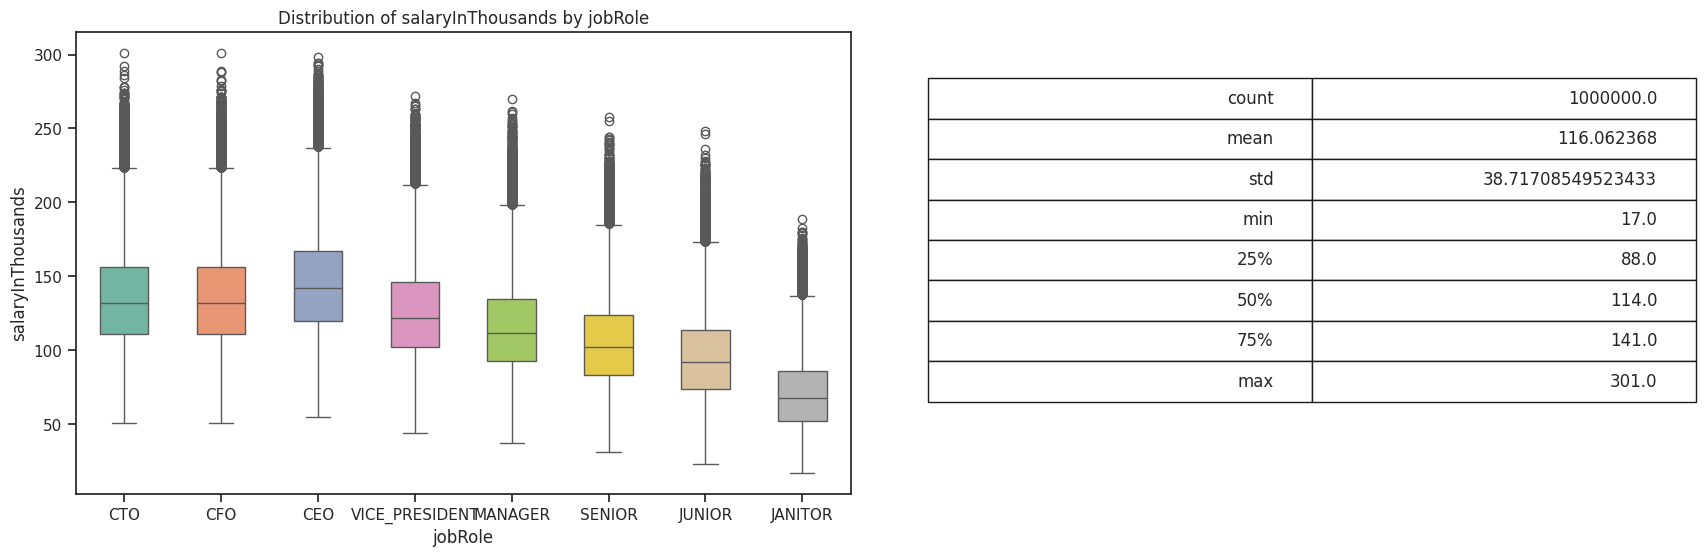

In [64]:
# Look at the distribution of different salaries for each jobRole after imputing for zeroes
statistics = pandas_df['salaryInThousands'].describe().to_dict()
df_sorted = pandas_df.sort_values(by='salaryInThousands', ascending=False)
plotBoxPlot(statistics, df_sorted,"jobRole","salaryInThousands", None,
            "Distribution of salaryInThousands by jobRole",
            "jobRole","salaryInThousands")

* Can be seen that there are a lot of outliers for each jobRole as there is a lot of variability, could be attributed to the differences in experience, major, education, etc
* CEO has the highest max, min and median salary
* However, due to sorting by the highest max salary, CTO and CFO are top 2 as each role has a person earning 301k
* Generally the median salary across all jobRoles is 114k, with a low min of 17k and high max of 301k - a difference of 284k
* Generally the IQR looks about the same for each jobRole, except for JANITOR; indicating that most job roles have a comparable spread of salaries

In [65]:
pandas_df[pandas_df['salaryInThousands']==301]

,jobId,companyId,jobRole,education,major,industry,yearsExperience,distanceFromCBD,salaryInThousands
400611,JOB1362684808298,COMP45,CFO,DOCTORAL,ENGINEERING,OIL,23,3,301.0
685562,JOB1362685093249,COMP47,CTO,MASTERS,ENGINEERING,OIL,24,0,301.0


In [66]:
pandas_df[pandas_df['salaryInThousands'] < 301].sort_values(by='salaryInThousands', ascending=False).head(10)

,jobId,companyId,jobRole,education,major,industry,yearsExperience,distanceFromCBD,salaryInThousands
572777,JOB1362684980464,COMP60,CEO,MASTERS,ENGINEERING,OIL,22,1,298.0
293221,JOB1362684700908,COMP44,CEO,DOCTORAL,ENGINEERING,OIL,19,18,294.0
911747,JOB1362685319434,COMP3,CEO,BACHELORS,BUSINESS,FINANCE,24,28,294.0
905713,JOB1362685313400,COMP35,CEO,DOCTORAL,BUSINESS,FINANCE,16,17,293.0
503962,JOB1362684911649,COMP3,CEO,DOCTORAL,PHYSICS,OIL,24,1,293.0
47203,JOB1362684454890,COMP18,CEO,BACHELORS,BUSINESS,FINANCE,22,18,292.0
884902,JOB1362685292589,COMP1,CTO,MASTERS,BUSINESS,FINANCE,24,2,292.0
377196,JOB1362684784883,COMP5,CEO,DOCTORAL,ENGINEERING,WEB,20,8,290.0
411881,JOB1362684819568,COMP43,CTO,MASTERS,ENGINEERING,WEB,24,17,289.0
470257,JOB1362684877944,COMP17,CFO,MASTERS,BUSINESS,OIL,23,12,289.0


Distribution of jobRoles

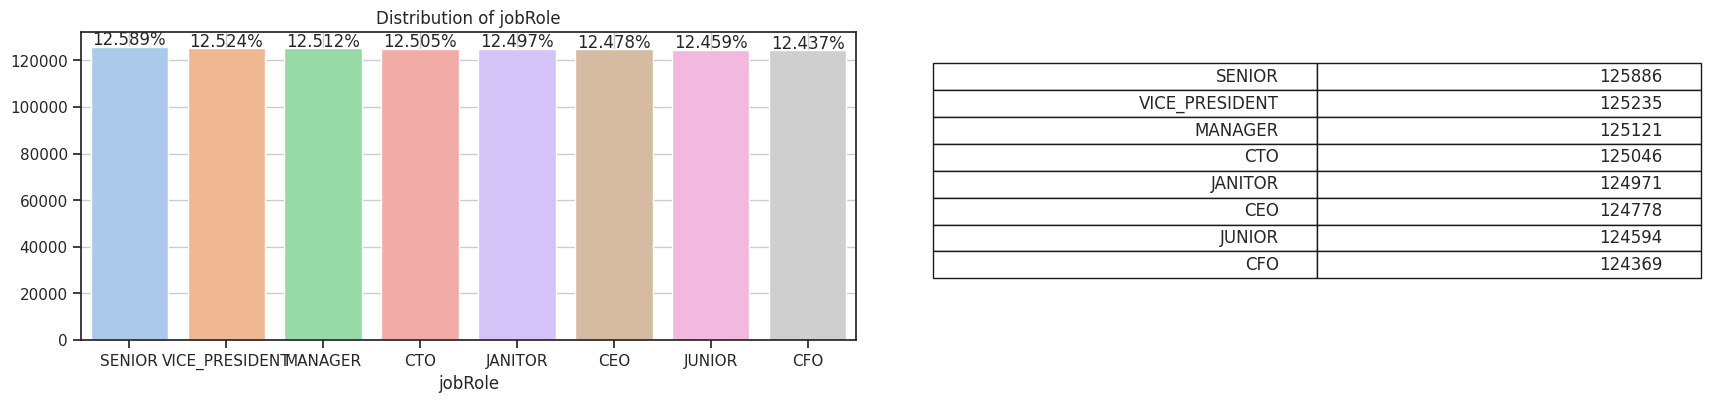

In [68]:
# Look at the distribution of jobRoles
plotBarPlot(pandas_df["jobRole"].value_counts().to_dict(), "jobRole")

Distribution of industries

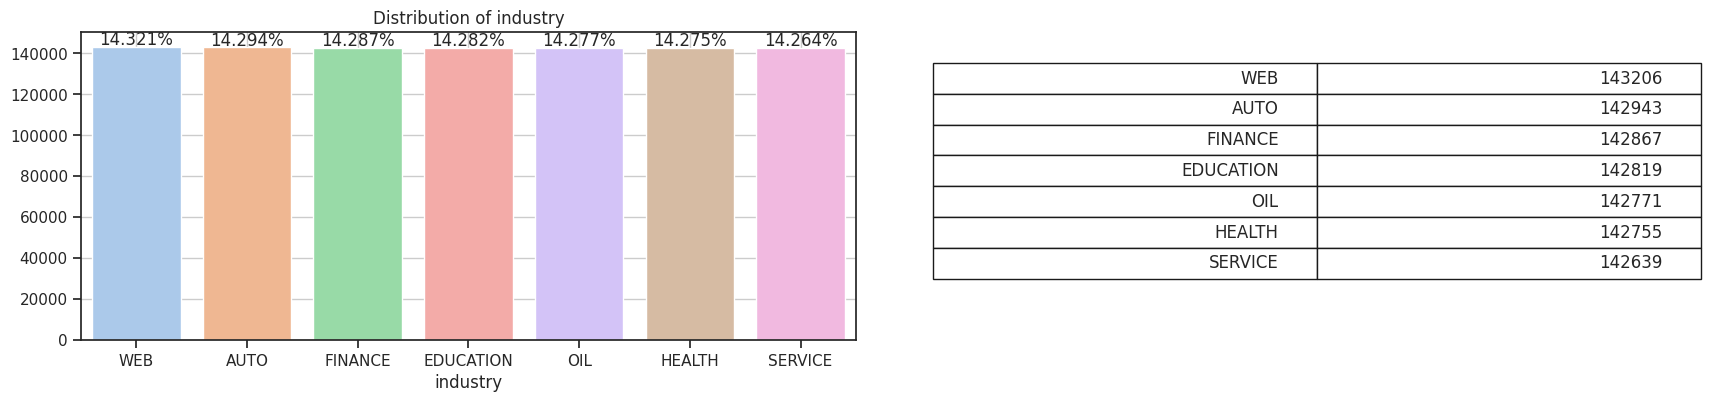

In [72]:
# Look at the distribution of industry
plotBarPlot(pandas_df["industry"].value_counts().to_dict(), "industry")

Distribution of majors

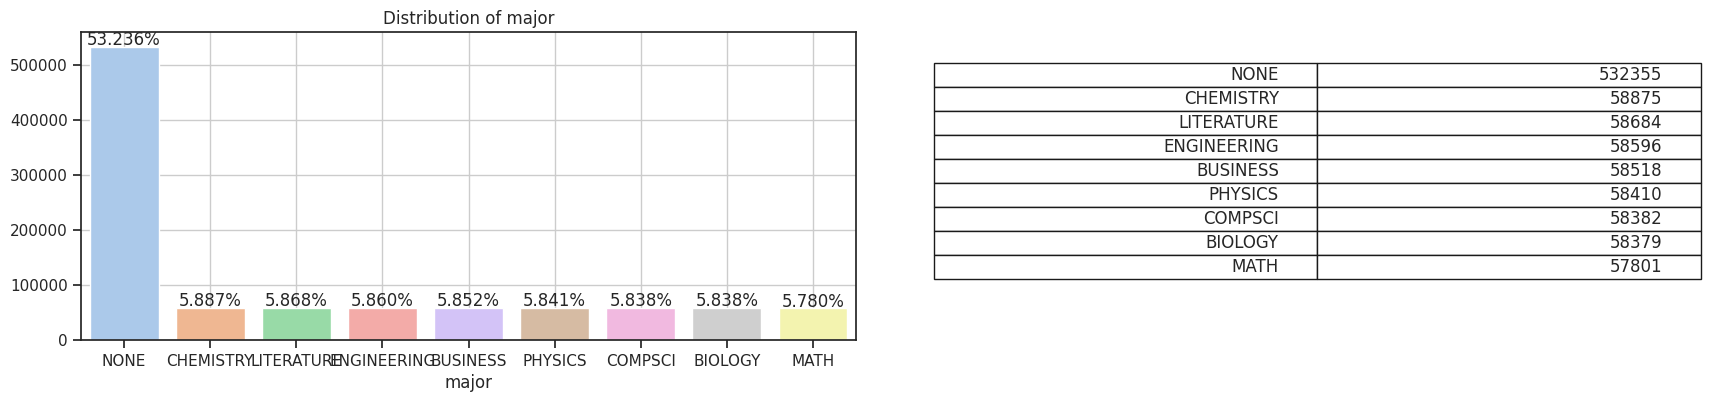

In [73]:
# Look at the distribution of majors
plotBarPlot(pandas_df["major"].value_counts().to_dict(), "major")

Distribution of education

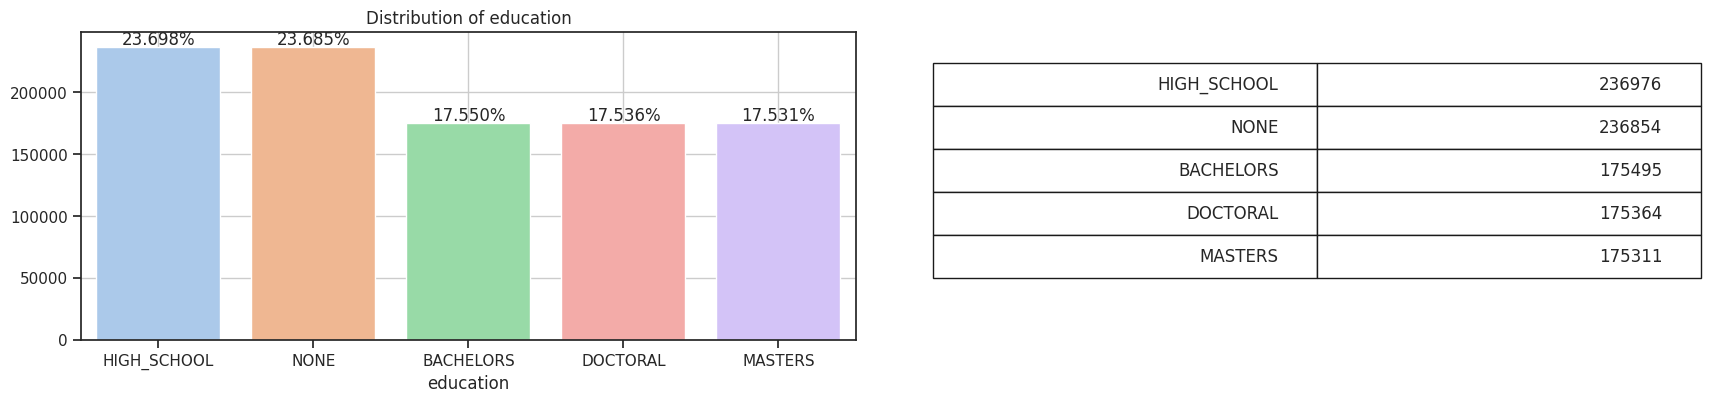

In [74]:
# Look at the distribution of education
plotBarPlot(pandas_df["education"].value_counts().to_dict(), "education")

Distribution of distanceFromCBD

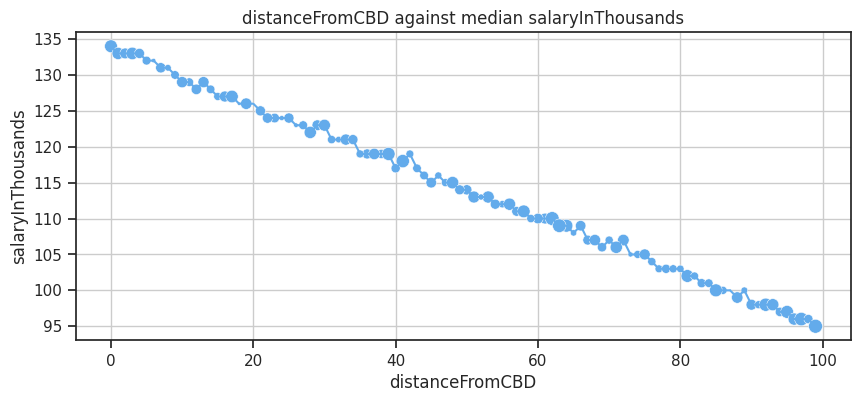

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
dist_agg = pandas_df.groupby(['distanceFromCBD',
                         ]).agg({'salaryInThousands': 'median',
                                 'jobId': 'count'
                                }).reset_index()
df_sorted = dist_agg.sort_values(by='salaryInThousands', ascending=False)
sns.lineplot(data=df_sorted, x='distanceFromCBD', y='salaryInThousands',
             color='#63abeb', markers=True).grid(True)
sns.scatterplot(data=df_sorted, x='distanceFromCBD', y='salaryInThousands',
                color='#63abeb', size='jobId', sizes=(1, 100), legend=False)
plt.title("distanceFromCBD against median salaryInThousands")
plt.show()

* Strong negative correlation between distanceFromCBD and salaryInThousands - as the distance increases, the median salary tends to decrease
* Higher-paying job opportunities being located within or closer to the CBD
* Approximately linear relationship
* Data points are evenly spread along the x-axis

Distribution of companies

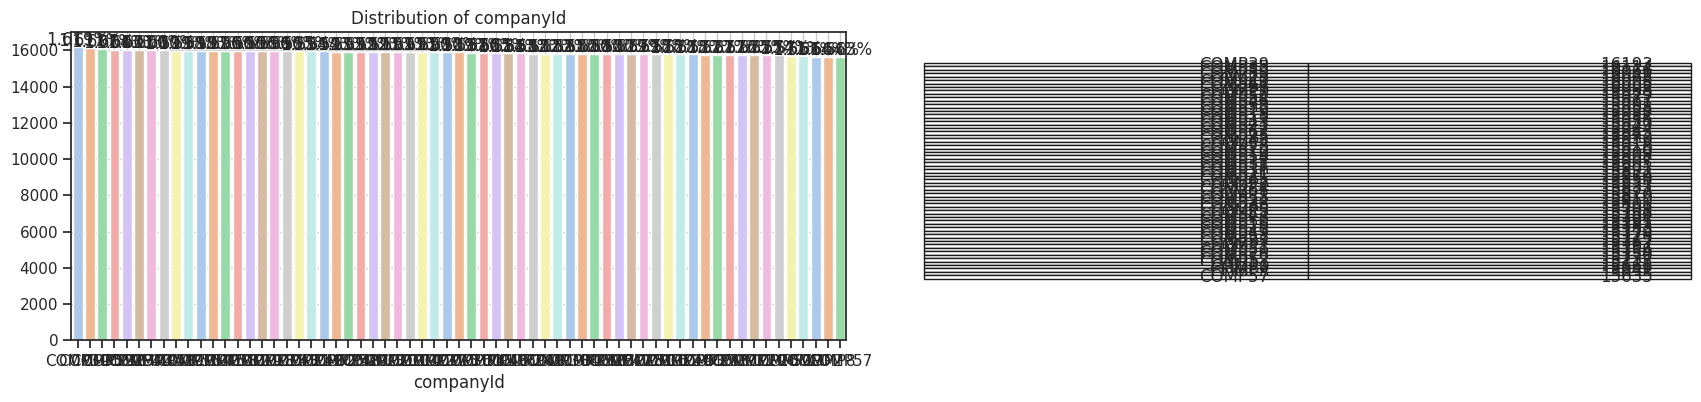

In [76]:
# Look at the distribution of companies
plotBarPlot(pandas_df["companyId"].value_counts().to_dict(), "companyId")

# 1. What is the highest paying job for the web industry

CEO is paid the highest

In [79]:
# Find the highest paying job in WEB
statement = """
SELECT jobRole,
       ROUND(MAX(salaryInThousands), 2) AS max_salary,
       ROUND(MEDIAN(salaryInThousands), 2) AS median_salary
FROM employees
WHERE industry = 'WEB'
GROUP BY jobRole
ORDER BY max_salary DESC
"""
# Show the results
spark.sql(statement).show()

+--------------+----------+-------------+
|       jobRole|max_salary|median_salary|
+--------------+----------+-------------+
|           CEO|     290.0|        147.0|
|           CTO|     289.0|        138.0|
|           CFO|     275.0|        138.0|
|VICE_PRESIDENT|     258.0|        128.0|
|       MANAGER|     253.0|        118.0|
|        SENIOR|     239.0|        108.0|
|        JUNIOR|     226.0|         98.0|
|       JANITOR|     169.0|         71.0|
+--------------+----------+-------------+



The highest paying job in the web industry is the CEO, with the chiefs earning the most
* Slight salary difference between CTO and CFO max salary, though the same in median - likely as WEB is highly focused on technology, and the role of the CTO might be more crucial for driving development, technological advancements, and maintaining competitive advantages as compared to CFO

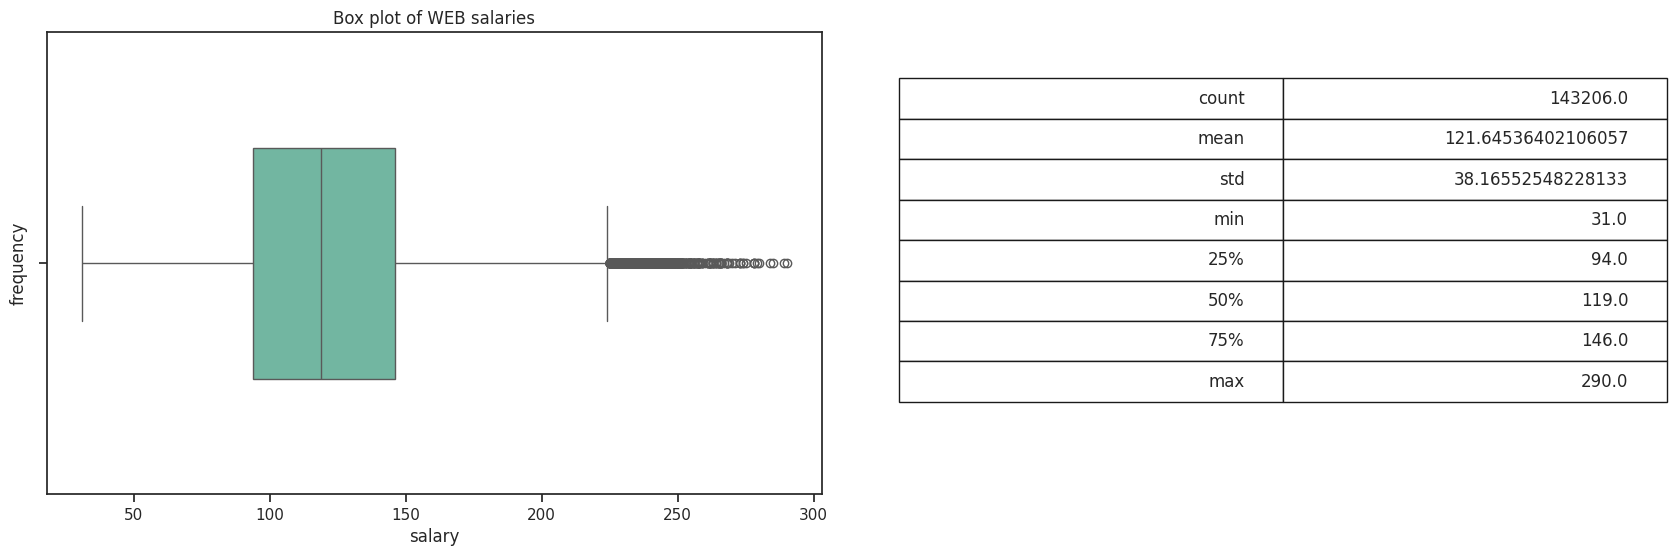

In [80]:
industry_list = pandas_df['industry'].unique()
industry_df = {}
for industry in industry_list:
    industry_df[industry] = pandas_df[pandas_df['industry'] == industry]
web_df = industry_df["WEB"]
statistics = web_df['salaryInThousands'].describe().to_dict()
df_sorted = industry_df["WEB"].sort_values(by='salaryInThousands', ascending=False)
plotBoxPlot(statistics, df_sorted, "salaryInThousands", None, None,
            "Box plot of WEB salaries", "salary", "frequency")

* Can be seen that the highest paid in WEB is 290k
* Std dev of 38.16 means a wide spread of salaries

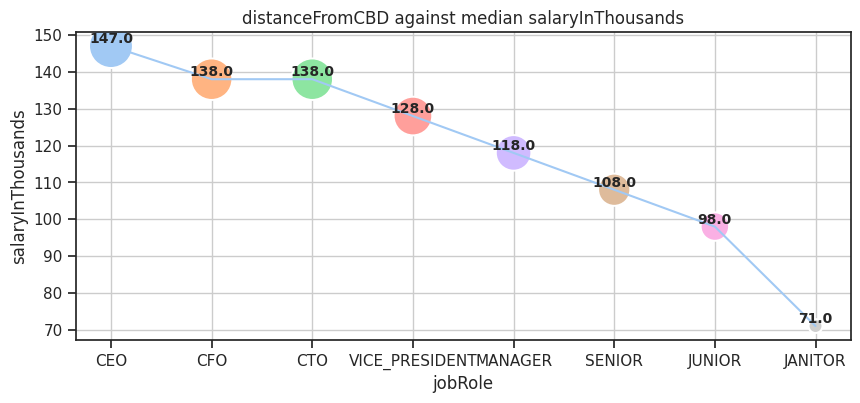

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
web_agg = web_df.groupby(['jobRole',
                         ]).agg({'salaryInThousands': 'median'
                                }).reset_index().sort_values(by='salaryInThousands', ascending=False)
sns.scatterplot(data=web_agg, x='jobRole', y='salaryInThousands',
                size='salaryInThousands', sizes=(100, 1000), hue = 'jobRole',
                legend=False)
sns.lineplot(data=web_agg, x='jobRole', y='salaryInThousands',
             markers=True).grid(True)
for i in range(web_agg.shape[0]):
    ax.text(x=web_agg.loc[i, 'jobRole'],
            y=web_agg.loc[i, 'salaryInThousands'],
            s=f"{web_agg.loc[i, 'salaryInThousands']}",
            ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.title("distanceFromCBD against median salaryInThousands")
plt.show()

The highest paying job in the web industry is the CEO, with the chiefs earning the most, and lesser spread between the CEO, CTO and CFO
* There is a jump of 20K in salary between VP and CFO
* A large and steep salary difference between JUNIOR and JANITOR
* Approximately linear relationship in salaries down the hierachy

# 2. Rank the top 10 job roles with the highest salary for all the industries

In [91]:
# Get distinct count of jobRoles
train_df.agg(countDistinct("jobRole").alias("jobRole_distinct_count")).show()
# Get nunique jobRoles
print(f"No of jobRoles in data = {pandas_df.jobRole.nunique()}")

+----------------------+
|jobRole_distinct_count|
+----------------------+
|                     8|
+----------------------+

No of jobRoles in data = 8


There are only 8 distinct jobRoles, hence, cannot rank the top 10 job roles - the two additional jobRoles were the friends we made along the way

In [92]:
# Use dense rank to ensure that rankings will be sequential
statement = """
SELECT jobRole,
      DENSE_RANK() OVER(ORDER BY MEDIAN(salaryInThousands) DESC) AS Rank,
      ROUND(MIN(salaryInThousands), 2) AS min_salary,
      ROUND(MAX(salaryInThousands), 2) AS max_salary,
      ROUND(MEDIAN(salaryInThousands), 2) AS median_salary
FROM employees
GROUP BY jobRole
"""
# Show the results
spark.sql(statement).show()

+--------------+----+----------+----------+-------------+
|       jobRole|Rank|min_salary|max_salary|median_salary|
+--------------+----+----------+----------+-------------+
|           CEO|   1|      55.0|     298.0|        142.0|
|           CTO|   2|      51.0|     301.0|        132.0|
|           CFO|   2|      51.0|     301.0|        132.0|
|VICE_PRESIDENT|   3|      44.0|     272.0|        122.0|
|       MANAGER|   4|      37.0|     270.0|        112.0|
|        SENIOR|   5|      31.0|     258.0|        102.0|
|        JUNIOR|   6|      23.0|     248.0|         92.0|
|       JANITOR|   7|      17.0|     189.0|         68.0|
+--------------+----+----------+----------+-------------+



* CTO and CFO earn the most in max salary, though they are below CEO in hierarchy - could be due to other attributes such as yearsExperience, education, etc that contributed to the high salary; as discovered in the understanding data section
* CEO is ranked first in terms of min, and median salary
* Follows hierarchical structure in salary where the chiefs earn the most, followed by middle management, and staff

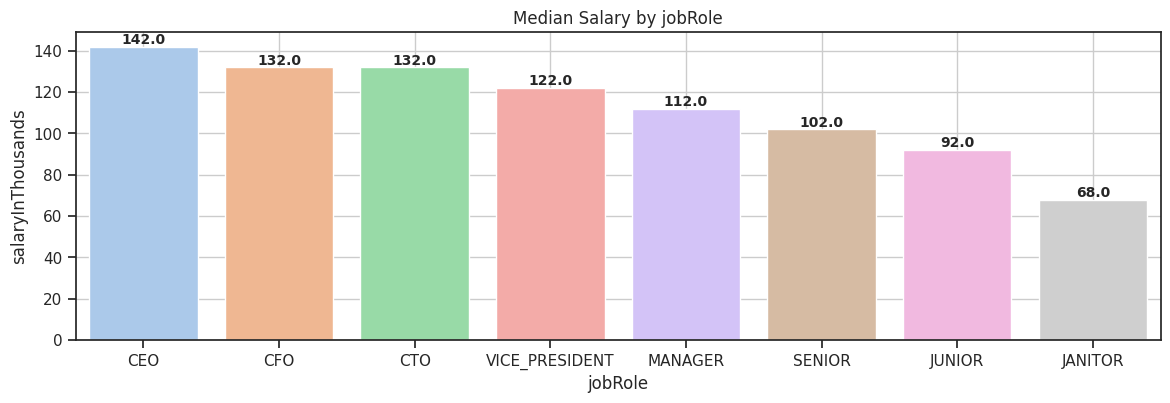

In [93]:
salary_agg = pandas_df.groupby(['jobRole',
                         ]).agg({'salaryInThousands': 'median',
                                }).reset_index().sort_values(by='salaryInThousands', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
sns.barplot(ax=ax, data=salary_agg, x='jobRole', y='salaryInThousands',
             palette='pastel').grid(True)
for i in range(salary_agg.shape[0]):
    ax.text(x=salary_agg.loc[i, 'jobRole'],
            y=salary_agg.loc[i, 'salaryInThousands'],
            s=f"{salary_agg.loc[i, 'salaryInThousands']}",
            ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.set_title('Median Salary by jobRole')
plt.show()

By median,
* The highest paid jobRole is CEO 142k
* Followed by CFO and CTO with similar salaries 132k
* The lowest paid jobRole is JANITOR 68k

## 3. Which of the industries has the highest salary

In [95]:
# Use dense rank to ensure that rankings will be sequential
statement = """
SELECT industry,
      DENSE_RANK() OVER(ORDER BY MAX(salaryInThousands) DESC) AS Rank,
      ROUND(MAX(salaryInThousands), 2) AS max_salary,
      ROUND(MEDIAN(salaryInThousands), 2) AS median_salary
FROM employees
GROUP BY industry
"""

# Show the results
spark.sql(statement).show()

+---------+----+----------+-------------+
| industry|Rank|max_salary|median_salary|
+---------+----+----------+-------------+
|      OIL|   1|     301.0|        128.0|
|  FINANCE|   2|     294.0|        128.0|
|      WEB|   3|     290.0|        119.0|
|   HEALTH|   4|     275.0|        114.0|
|     AUTO|   5|     264.0|        108.0|
|  SERVICE|   6|     256.0|        103.0|
|EDUCATION|   7|     253.0|         98.0|
+---------+----+----------+-------------+



Ranked industries based on their maximum salary, OIL has the highest max and average salary, followed by FINANCE, however does not give a very comprehensive understanding as there is variation between higher paying jobs and lower paying jobs.

In [96]:
# Use rank to rank generally
statement = """
SELECT *
FROM(
    SELECT industry, jobRole,
        RANK() OVER(PARTITION BY jobRole ORDER BY MAX(salaryInThousands) DESC) AS max_Rank,
        ROUND(MAX(salaryInThousands), 2) AS max_salary,
        RANK() OVER(PARTITION BY jobRole ORDER BY MEDIAN(salaryInThousands) DESC) AS median_Rank,
        ROUND(MEDIAN(salaryInThousands), 2) AS median_salary
    FROM employees
    GROUP BY industry, jobRole
    )
WHERE max_Rank = 1
ORDER BY max_salary DESC
"""
# Show the results
spark.sql(statement).show()

+--------+--------------+--------+----------+-----------+-------------+
|industry|       jobRole|max_Rank|max_salary|median_Rank|median_salary|
+--------+--------------+--------+----------+-----------+-------------+
|     OIL|           CFO|       1|     301.0|          1|        147.0|
|     OIL|           CTO|       1|     301.0|          1|        147.0|
|     OIL|           CEO|       1|     298.0|          1|        157.0|
|     OIL|VICE_PRESIDENT|       1|     272.0|          1|        137.0|
|     OIL|       MANAGER|       1|     270.0|          1|        127.0|
|     OIL|        SENIOR|       1|     258.0|          1|        117.0|
| FINANCE|        JUNIOR|       1|     248.0|          1|        107.0|
| FINANCE|       JANITOR|       1|     189.0|          1|         82.0|
+--------+--------------+--------+----------+-----------+-------------+



Zooming in, OIL is the highest paying industry overall, ranking no.1 in max salaries, and median salary; however, for JUNIOR and JANITOR, FINANCE pays better
* CTO and CFO have similar max salaries and median salary
* OIL and FINANCE pays better due to the complexity and risks of the industry
* Higher complexity, higher requirements for specialized skills, expertise and talent
* Market demand for OIL and FINANCE needs

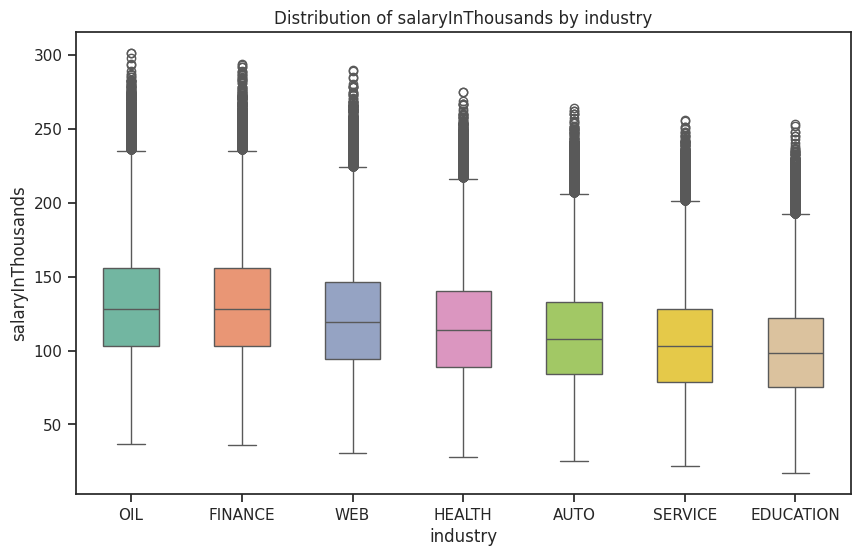

In [97]:
df_sorted = pandas_df.sort_values(by='salaryInThousands', ascending=False)
plotBoxPlot(None, df_sorted,"industry","salaryInThousands", None,
            "Distribution of salaryInThousands by industry",
            "industry","salaryInThousands")

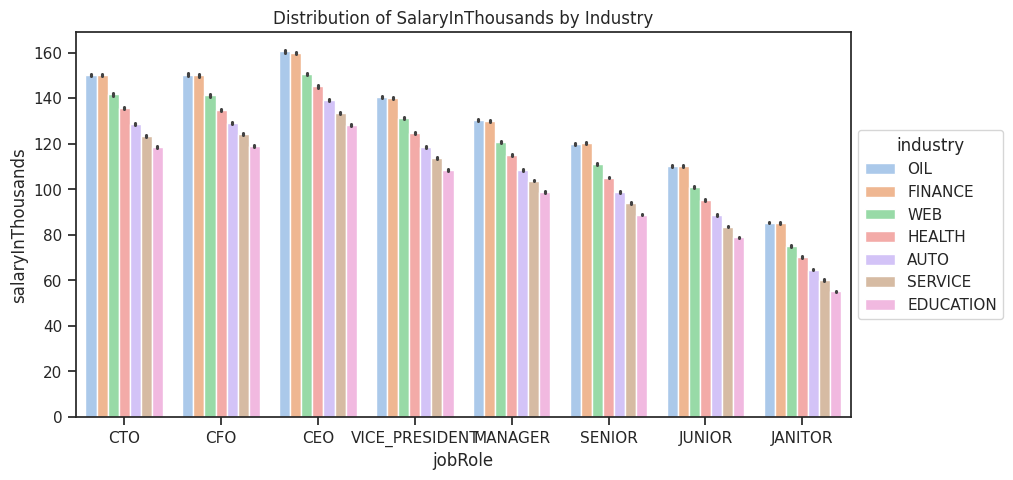

In [101]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobRole', y = 'salaryInThousands', data=pandas_df.sort_values(by='salaryInThousands', ascending=False), hue='industry')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='industry')
plt.title('Distribution of SalaryInThousands by Industry')
plt.show()

Can be seen that OIL and FINANCE both pay the highest in salary, and quite similar

## 4. Which job has the lowest pay

JANITOR has the lowest pay
* Often requires minimal formal education or specialized training compared to other roles
* Skills required are generally less specialized and can be learned quickly, leading to lower salary
* Lower level of responsibility and low level of complexity to the job

In [99]:
# Use dense rank to ensure that rankings will be sequential
statement = """
SELECT DENSE_RANK() OVER(ORDER BY MAX(salaryInThousands) ASC) AS Rank,
  jobRole,
  ROUND(MAX(salaryInThousands), 2) AS max_salary,
  ROUND(MEDIAN(salaryInThousands), 2) AS median_salary
FROM employees
GROUP BY jobRole
"""
# Show the results
spark.sql(statement).show()

+----+--------------+----------+-------------+
|Rank|       jobRole|max_salary|median_salary|
+----+--------------+----------+-------------+
|   1|       JANITOR|     189.0|         68.0|
|   2|        JUNIOR|     248.0|         92.0|
|   3|        SENIOR|     258.0|        102.0|
|   4|       MANAGER|     270.0|        112.0|
|   5|VICE_PRESIDENT|     272.0|        122.0|
|   6|           CEO|     298.0|        142.0|
|   7|           CTO|     301.0|        132.0|
|   7|           CFO|     301.0|        132.0|
+----+--------------+----------+-------------+



JANITOR has the lowest max (189.0) and median (68.0) salaries, making them overall the lowest paying job, followed by JUNIOR - max (248.0) and median (92.0)
* JUNIOR likely has lower yearsExperience, leading to lower salary

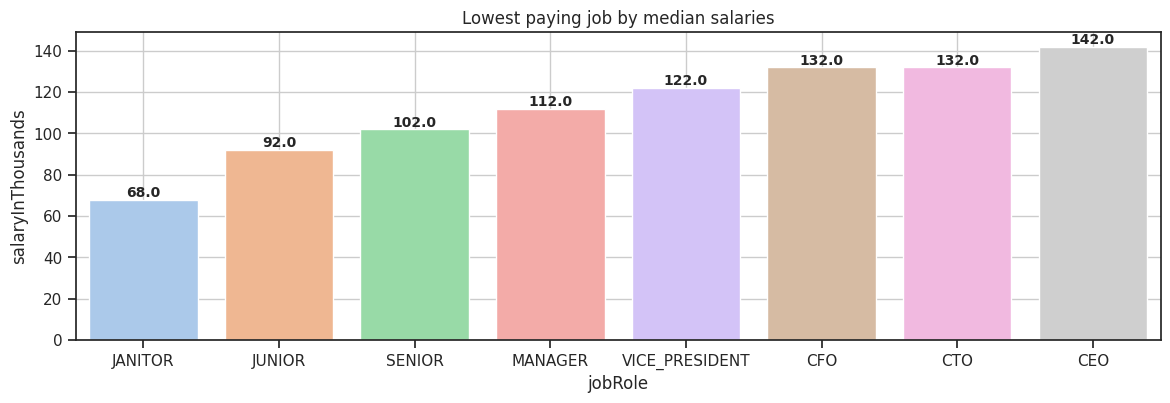

In [94]:
salary_agg = pandas_df.groupby(['jobRole',
                         ]).agg({'salaryInThousands': 'median',
                                }).reset_index().sort_values(by='salaryInThousands', ascending=True)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
sns.barplot(data=salary_agg, x='jobRole', y='salaryInThousands',
             palette="pastel").grid(True)
for i in range(salary_agg.shape[0]):
    ax.text(x=salary_agg.loc[i, 'jobRole'],
            y=salary_agg.loc[i, 'salaryInThousands'],
            s=f"{salary_agg.loc[i, 'salaryInThousands']}",
            ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.title("Lowest paying job by median salaries")
plt.show()

## 5. Which industries have the lowest pay?

EDUCATION has the lowest minimum salary, median salary and max salary
* After EDUCATION, follows SERVICE - such industries are usually paid less
* Likely due to public and private sector dynamics where education is more likely to be public schools, etc - where public sector jobs often have budget constraints and are influenced by government policies, which can limit the salary growth in these sectors
* EDUCATION and SERVICE industries often don't generate the same level of profits as compared to OIL and FINANCE, leading to lower pay

In [102]:
# Use dense rank to ensure that rankings will be sequential
statement = """
SELECT industry,
      DENSE_RANK() OVER(ORDER BY MIN(salaryInThousands) ASC) AS Rank,
      ROUND(MIN(salaryInThousands), 2) AS min_salary,
      ROUND(MEDIAN(salaryInThousands), 2) AS median_salary,
      ROUND(MAX(salaryInThousands), 2) AS max_salary
FROM employees
GROUP BY industry
"""

# Show the results
spark.sql(statement).show()

+---------+----+----------+-------------+----------+
| industry|Rank|min_salary|median_salary|max_salary|
+---------+----+----------+-------------+----------+
|EDUCATION|   1|      17.0|         98.0|     253.0|
|  SERVICE|   2|      22.0|        103.0|     256.0|
|     AUTO|   3|      25.0|        108.0|     264.0|
|   HEALTH|   4|      28.0|        114.0|     275.0|
|      WEB|   5|      31.0|        119.0|     290.0|
|  FINANCE|   6|      36.0|        128.0|     294.0|
|      OIL|   7|      37.0|        128.0|     301.0|
+---------+----+----------+-------------+----------+



EDUCATION has the lowest minimum salary 17k, median salary 98k and max salary 253k


In [103]:
# Use rank to rank generally
statement = """
SELECT *
FROM(
    SELECT industry, jobRole,
        RANK() OVER(PARTITION BY jobRole ORDER BY MIN(salaryInThousands) ASC) AS min_Rank,
        ROUND(MIN(salaryInThousands), 2) AS min_salary,
        RANK() OVER(PARTITION BY jobRole ORDER BY MEDIAN(salaryInThousands) ASC) AS median_Rank,
        ROUND(MEDIAN(salaryInThousands), 2) AS median_salary
    FROM employees
    GROUP BY industry, jobRole
    )
WHERE min_Rank = 1
ORDER BY min_salary DESC
"""
# Show the results
spark.sql(statement).show()

+---------+--------------+--------+----------+-----------+-------------+
| industry|       jobRole|min_Rank|min_salary|median_Rank|median_salary|
+---------+--------------+--------+----------+-----------+-------------+
|EDUCATION|           CEO|       1|      55.0|          1|        125.0|
|EDUCATION|           CFO|       1|      51.0|          1|        116.0|
|EDUCATION|           CTO|       1|      51.0|          1|        116.0|
|EDUCATION|VICE_PRESIDENT|       1|      44.0|          1|        105.0|
|EDUCATION|       MANAGER|       1|      37.0|          1|         96.0|
|EDUCATION|        SENIOR|       1|      31.0|          1|         86.0|
|EDUCATION|        JUNIOR|       1|      23.0|          1|         76.0|
|EDUCATION|       JANITOR|       1|      17.0|          1|         51.0|
+---------+--------------+--------+----------+-----------+-------------+



Overall, EDUCATION is the lowest paying industry, with the lowest minimum salaries, and lowest median salaries for each jobRole

In comparison to OIL where the CEO's median salary is  157.0 and SENIOR's median salary is 117.0; salaries in EDUCATION and OIL have a difference of ~30k

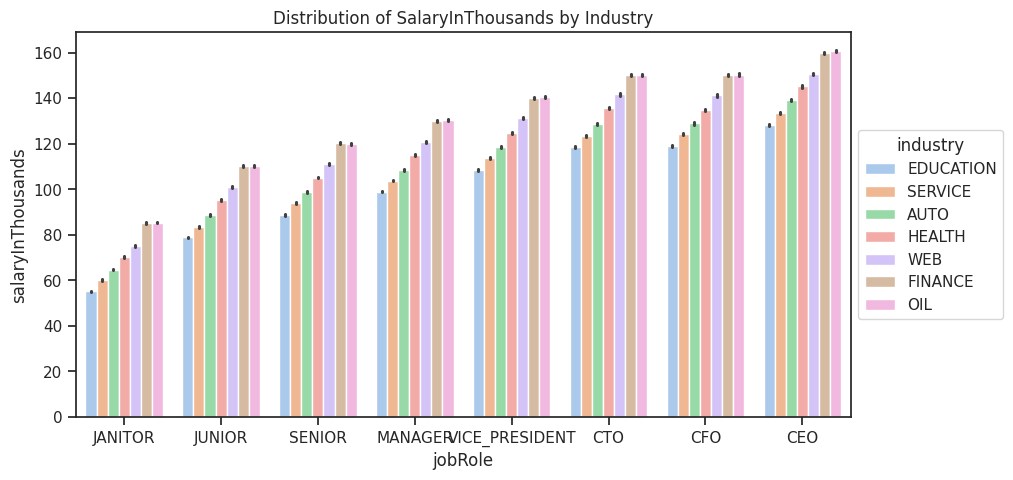

In [100]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobRole', y = 'salaryInThousands', data=pandas_df.sort_values(by='salaryInThousands', ascending=True), hue='industry')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='industry')
plt.title('Distribution of SalaryInThousands by Industry')
plt.show()

Zooming in, across all the different jobRoles, EDUCATION and SERVICE has the lowest salaryInThousands

OIL, and FINANCE have the highest salaryInThousands

## 6. Given that the median salary per year is $114,000
### A. Which industry has the highest percentage of people who are below the median salary

In [104]:
statement = """
WITH total_count AS (
  SELECT industry, COUNT(*) AS total_counts
  FROM employees
  GROUP BY industry
),
below_median_count AS (
  SELECT industry, COUNT(*) AS below_median_total
  FROM employees
  WHERE salaryInThousands < 114
  GROUP BY industry
)
SELECT DENSE_RANK() OVER(ORDER BY percentage DESC) AS rank, *
FROM(
  SELECT tc.industry, tc.total_counts, bmc.below_median_total,
    ROUND(((bmc.below_median_total / tc.total_counts) * 100), 2) AS percentage
  FROM total_count tc
  JOIN below_median_count bmc
  ON tc.industry = bmc.industry
)
"""
# Show the results
spark.sql(statement).show()

+----+---------+------------+------------------+----------+
|rank| industry|total_counts|below_median_total|percentage|
+----+---------+------------+------------------+----------+
|   1|EDUCATION|      142819|             95503|     66.87|
|   2|  SERVICE|      142639|             88014|      61.7|
|   3|     AUTO|      142943|             80685|     56.45|
|   4|   HEALTH|      142755|             71009|     49.74|
|   5|      WEB|      143206|             62721|      43.8|
|   6|      OIL|      142771|             49526|     34.69|
|   7|  FINANCE|      142867|             49536|     34.67|
+----+---------+------------+------------------+----------+



EDUCATION has the highest percentage of people who are below the median salary (66.87), followed by SERVICE (61.7) and the lowest percentage of people below median salary is FINANCE (34.67)
* This mirrors the ranking for lowest paying industries
* FINANCE has the lowest percentage of people getting paid below median (34.67) followed by OIL (34.69)

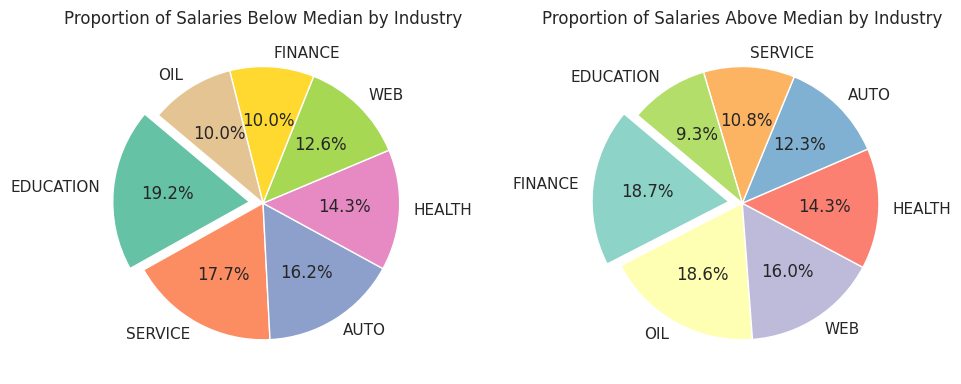

In [106]:
# Sort by below and above the median salary
below_median_df = pandas_df[pandas_df['salaryInThousands'] < 114]
above_median_df = pandas_df[pandas_df['salaryInThousands'] > 114]

bmc = below_median_df.industry.value_counts().sort_values(ascending=False)
amc = above_median_df.industry.value_counts().sort_values(ascending=False)
explode_bmc = [0.1 if i == 0 else 0 for i in range(len(bmc))]
explode_amc = [0.1 if i == 0 else 0 for i in range(len(amc))]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].pie(bmc, labels=bmc.index, autopct='%1.1f%%', startangle=140,
          colors=sns.color_palette('Set2'), explode=explode_bmc)
ax[0].set_title('Proportion of Salaries Below Median by Industry')
ax[1].pie(amc, labels=amc.index, autopct='%1.1f%%', startangle=140,
          colors=sns.color_palette('Set3'), explode=explode_amc)
ax[1].set_title('Proportion of Salaries Above Median by Industry')
plt.tight_layout()
plt.show()

### B. What are the job roles that are below the median salary?

In [105]:
statement = """
WITH total_count AS (
  SELECT jobRole, COUNT(*) AS total_counts
  FROM employees
  GROUP BY jobRole
),
below_median_count AS (
  SELECT jobRole, COUNT(*) AS below_median_total
  FROM employees
  WHERE salaryInThousands < 114
  GROUP BY jobRole
)
SELECT DENSE_RANK() OVER(ORDER BY percentage DESC) AS rank, *
FROM(
  SELECT tc.jobRole, tc.total_counts, bmc.below_median_total,
    ROUND(((bmc.below_median_total / tc.total_counts) * 100), 2) AS percentage
  FROM total_count tc
  JOIN below_median_count bmc
  ON tc.jobRole = bmc.jobRole
)
"""
# Show the results
spark.sql(statement).show()

+----+--------------+------------+------------------+----------+
|rank|       jobRole|total_counts|below_median_total|percentage|
+----+--------------+------------+------------------+----------+
|   1|       JANITOR|      124971|            117438|     93.97|
|   2|        JUNIOR|      124594|             93443|      75.0|
|   3|        SENIOR|      125886|             80527|     63.97|
|   4|       MANAGER|      125121|             64832|     51.82|
|   5|VICE_PRESIDENT|      125235|             49135|     39.23|
|   6|           CTO|      125046|             34433|     27.54|
|   6|           CFO|      124369|             34248|     27.54|
|   7|           CEO|      124778|             22938|     18.38|
+----+--------------+------------+------------------+----------+



JANITORs have the highest percentage of people earning below the median salary (93.97) which is majority of the people working as JANITORs, only a small minority (~6) earn above 114.
* Followed by JUNIOR (75) and SENIOR (63.97)
* CEO has the lowest percentage of people earning below median salary (18.38)
* Generally only CEO, CFO, CTO are more likely to be paid above median salary, and the other job roles are significantly less likely to

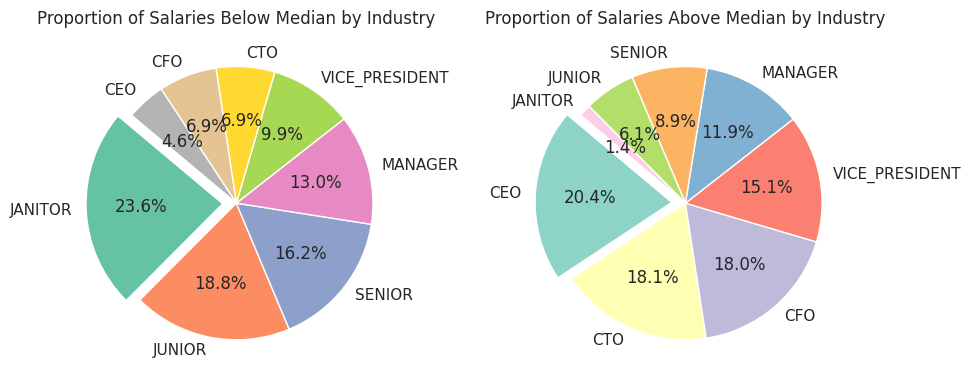

In [107]:
bmc = below_median_df.jobRole.value_counts().sort_values(ascending=False)
amc = above_median_df.jobRole.value_counts().sort_values(ascending=False)
explode_bmc = [0.1 if i == 0 else 0 for i in range(len(bmc))]
explode_amc = [0.1 if i == 0 else 0 for i in range(len(amc))]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].pie(bmc, labels=bmc.index, autopct='%1.1f%%', startangle=140,
          colors=sns.color_palette('Set2'), explode=explode_bmc)
ax[0].set_title('Proportion of Salaries Below Median by Industry')
ax[1].pie(amc, labels=amc.index, autopct='%1.1f%%', startangle=140,
          colors=sns.color_palette('Set3'), explode=explode_amc)
ax[1].set_title('Proportion of Salaries Above Median by Industry')
plt.tight_layout()
plt.show()

## 7. Determine if there is a relationship between years of experience and salary

In [108]:
# Using corr() function to find the correlation
statement = """
SELECT corr(yearsExperience, salaryInThousands) AS correlation_coefficient
FROM employees
"""
# Show the results
spark.sql(statement).show()

+-----------------------+
|correlation_coefficient|
+-----------------------+
|      0.375012564037878|
+-----------------------+



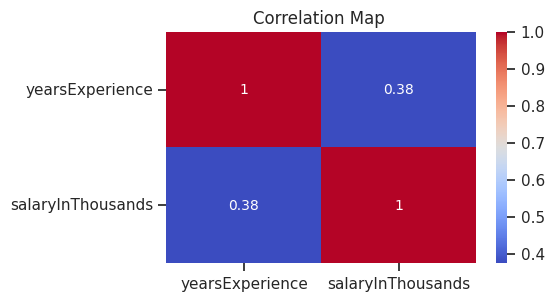

<Figure size 500x300 with 0 Axes>

In [113]:
df_corr = pandas_df[['yearsExperience','salaryInThousands']]
# Plot correlation map
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
plotCorrMap(df_corr, df_corr.columns, "", axs)

Shows a moderate correlation between years of experience and salary

In [114]:
statement = """
WITH total_count AS (
  SELECT COUNT(*) AS total_counts
  FROM employees
),
experience AS (
  SELECT
      CASE
          WHEN yearsExperience BETWEEN 0 AND 2 THEN '0-2 years'
          WHEN yearsExperience BETWEEN 3 AND 5 THEN '3-5 years'
          WHEN yearsExperience BETWEEN 6 AND 10 THEN '6-10 years'
          WHEN yearsExperience BETWEEN 11 AND 20 THEN '11-20 years'
          WHEN yearsExperience > 20 THEN '>20 years'
      END AS experienceRange,
      ROUND(MIN(salaryInThousands),2) AS min_salary,
      ROUND(MAX(salaryInThousands),2) AS max_salary,
      ROUND(MEDIAN(salaryInThousands),2) AS median_salary,
      COUNT(*) AS employeeCount
  FROM employees
  GROUP BY
      CASE
          WHEN yearsExperience BETWEEN 0 AND 2 THEN '0-2 years'
          WHEN yearsExperience BETWEEN 3 AND 5 THEN '3-5 years'
          WHEN yearsExperience BETWEEN 6 AND 10 THEN '6-10 years'
          WHEN yearsExperience BETWEEN 11 AND 20 THEN '11-20 years'
          WHEN yearsExperience > 20 THEN '>20 years'
      END
)
SELECT DENSE_RANK() OVER(ORDER BY e.median_salary DESC) AS rank,
  e.experienceRange, e.min_salary, e.max_salary, e.median_salary,
  ROUND(((e.employeeCount / tc.total_counts) * 100), 2) AS percentageOfEmployees
FROM experience e, total_count tc
"""
# Show the results
spark.sql(statement).show()

+----+---------------+----------+----------+-------------+---------------------+
|rank|experienceRange|min_salary|max_salary|median_salary|percentageOfEmployees|
+----+---------------+----------+----------+-------------+---------------------+
|   1|      >20 years|      32.0|     301.0|        135.0|                15.98|
|   2|    11-20 years|      25.0|     294.0|        121.0|                39.93|
|   3|     6-10 years|      21.0|     263.0|        107.0|                20.05|
|   4|      3-5 years|      21.0|     245.0|         99.0|                12.02|
|   5|      0-2 years|      17.0|     229.0|         93.0|                12.01|
+----+---------------+----------+----------+-------------+---------------------+



There is a relationship between the salary and years of experience
* People with the highest number of yearsExperience (>20 years) has the highest earning potential in min, max and median salary
* Between 3-5, and 6-10 years experience, both have the same min salary
* Entry level (0-2 years) has the lowest earning potential, with the lowest min, max and median salary
* Additionally, majority of people have 11-20 years worth of experience (39.93%), reflecting the number of people with SENIOR jobRole


People with more experience are more likely to earn more in comparison to those who are just entry level

In [115]:
# Convert to pandas for graphing
experience_range_df = spark.sql(statement).toPandas()

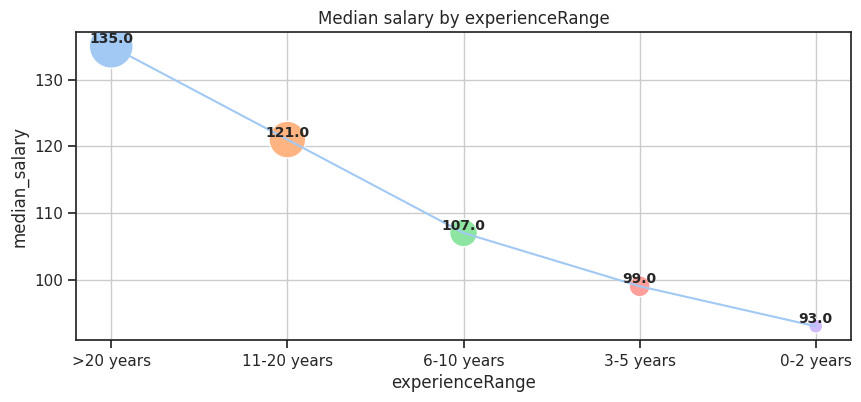

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.scatterplot(data=experience_range_df, x='experienceRange', y='median_salary',
                size='median_salary', sizes=(100, 1000), hue = 'experienceRange',
                legend=False)
sns.lineplot(data=experience_range_df, x='experienceRange', y='median_salary',
             markers=True).grid(True)
for i in range(experience_range_df.shape[0]):
    ax.text(x=experience_range_df.loc[i, 'experienceRange'],
            y=experience_range_df.loc[i, 'median_salary'],
            s=f"{experience_range_df.loc[i, 'median_salary']}",
            ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.title("Median salary by experienceRange")
plt.show()

* Approximately linear relationship

## 8. Is there a relationship between education and salary

People with higher education are more likely to have higher earning potential in comparison to those with HIGH_SCHOOL or NONE education

In [118]:
statement = """
SELECT DENSE_RANK() OVER(ORDER BY median_salary DESC) AS rank, *
FROM(
  SELECT education,
  ROUND(MEDIAN(salaryInThousands), 2) AS median_salary,
  ROUND(MIN(salaryInThousands), 2) AS min_salary,
  ROUND(MAX(salaryInThousands), 2) AS max_salary,
  ROUND(STDDEV(salaryInThousands), 2) AS salary_stddev
  FROM employees
  GROUP BY education
)
"""
# Show the results
spark.sql(statement).show()

+----+-----------+-------------+----------+----------+-------------+
|rank|  education|median_salary|min_salary|max_salary|salary_stddev|
+----+-----------+-------------+----------+----------+-------------+
|   1|   DOCTORAL|        132.0|      45.0|     301.0|        35.79|
|   2|    MASTERS|        127.0|      38.0|     301.0|         35.4|
|   3|  BACHELORS|        122.0|      35.0|     294.0|        35.04|
|   4|HIGH_SCHOOL|         99.0|      18.0|     260.0|        36.11|
|   5|       NONE|         95.0|      17.0|     254.0|        34.92|
+----+-----------+-------------+----------+----------+-------------+



* People with higher education have more earning potential, maxxing out their earning potential at ~280k in comparison to those with HIGH_SCHOOL or NONE maxxing out at ~255k
* The min salary between HIGH_SCHOOL and NONE, and higher education is a big difference of ~15k
* DOCTORAL has the highest median salary at 132k, followed by MASTERS and BACHELORS - which reflects the higher level of study, the higher earning potential

In [119]:
# Convert to pandas for graphing
education_salary_df = spark.sql(statement).toPandas()

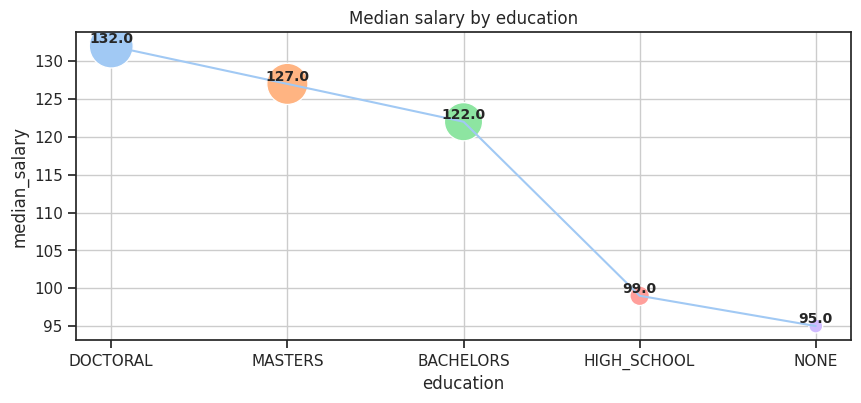

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.scatterplot(data=education_salary_df, x='education', y='median_salary',
                size='median_salary', sizes=(100, 1000), hue = 'education',
                legend=False)
sns.lineplot(data=education_salary_df, x='education', y='median_salary',
             markers=True).grid(True)
for i in range(education_salary_df.shape[0]):
    ax.text(x=education_salary_df.loc[i, 'education'],
            y=education_salary_df.loc[i, 'median_salary'],
            s=f"{education_salary_df.loc[i, 'median_salary']}",
            ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.title("Median salary by education")
plt.show()

There is an approximately linear relationship, however there is a steep difference between the median pay of BACHELOR majors and HIGH_SCHOOL and NONE majors

## 9. Does the major studied affect the salary

In [111]:
statement = """
WITH base_df AS (
  SELECT DENSE_RANK() OVER(ORDER BY median_salary DESC) AS rank, *
  FROM(
    SELECT major,
    ROUND(MEDIAN(salaryInThousands), 2) AS median_salary,
    ROUND(MIN(salaryInThousands), 2) AS min_salary,
    ROUND(MAX(salaryInThousands), 2) AS max_salary,
    ROUND(STDDEV(salaryInThousands), 2) AS salary_stddev
    FROM employees
    GROUP BY major
  )
)
SELECT *
FROM base_df
"""
spark.sql(statement).show()

+----+-----------+-------------+----------+----------+-------------+
|rank|      major|median_salary|min_salary|max_salary|salary_stddev|
+----+-----------+-------------+----------+----------+-------------+
|   1|ENGINEERING|        135.0|      41.0|     301.0|        38.18|
|   2|   BUSINESS|        132.0|      40.0|     294.0|        37.01|
|   3|       MATH|        130.0|      39.0|     280.0|        35.54|
|   4|    COMPSCI|        129.0|      41.0|     286.0|        34.78|
|   5|    PHYSICS|        127.0|      38.0|     293.0|        34.96|
|   6|  CHEMISTRY|        126.0|      40.0|     282.0|        34.83|
|   7|    BIOLOGY|        125.0|      35.0|     285.0|        34.82|
|   8| LITERATURE|        122.0|      37.0|     271.0|        33.58|
|   9|       NONE|        100.0|      17.0|     270.0|        36.14|
+----+-----------+-------------+----------+----------+-------------+



A large standard deviation indicates that there is a lot of variance
* ENGINEERING and BUSINESS have higher median, min, and max salary - with the highest std deviation which indicates that there is a potential for exceptionally high earnings
* NONE has the lowest median, min and max salary with high std deviation - indicating more variability and generally lower earning potential

In [112]:
statement = """
WITH base_df AS (
  SELECT DENSE_RANK() OVER(ORDER BY median_salary DESC) AS rank, *
  FROM(
    SELECT major,
    ROUND(MEDIAN(salaryInThousands), 2) AS median_salary,
    ROUND(MIN(salaryInThousands), 2) AS min_salary,
    ROUND(MAX(salaryInThousands), 2) AS max_salary
    FROM employees
    GROUP BY major
  )
),
highest_median AS (
  SELECT median_salary AS highest_median_salary
  FROM base_df
  WHERE rank = 1
)
SELECT b.rank, b.major, b.median_salary,
  ROUND((((h.highest_median_salary - b.median_salary) / h.highest_median_salary) * 100), 2) AS percentage_difference
FROM base_df b
JOIN highest_median h
"""
# Show the results
spark.sql(statement).show()

+----+-----------+-------------+---------------------+
|rank|      major|median_salary|percentage_difference|
+----+-----------+-------------+---------------------+
|   1|ENGINEERING|        135.0|                  0.0|
|   2|   BUSINESS|        132.0|                 2.22|
|   3|       MATH|        130.0|                  3.7|
|   4|    COMPSCI|        129.0|                 4.44|
|   5|    PHYSICS|        127.0|                 5.93|
|   6|  CHEMISTRY|        126.0|                 6.67|
|   7|    BIOLOGY|        125.0|                 7.41|
|   8| LITERATURE|        122.0|                 9.63|
|   9|       NONE|        100.0|                25.93|
+----+-----------+-------------+---------------------+



Looking at the difference between highest median salary and difference between each major's median salary provides insights into how salaries vary across different majors
* This helps identify which majors have significantly lower or higher median salaries relative to the top major
* NONE has the lowest median salary (100k) in comparison to the other majors, and has the biggest percentage difference (25.93)
* The discrepancy between majors is about 2~10%
* Highlights the salaries across different fields - could be that certain majors are more sought after, resulting in higher earning potential

Major does affect the salaries as reflected, that the NONE major has the lowest median, min and max salary. Those with majors are more likely to have higher earning potential, as reflected from the type of education

# Insights and findings for model training
* Data is highly equally distributed with data points spreading out evenly across the range of possible values
* Across the columns of data, have approximately linear relationships
* Most columns hold high significance towards salaryInThousands such as jobRole,yearsExperience, industry, etc

Linear regression would the best for this task by leveraging the approximately linear relationships present in the data

# Conclusion of EDA

In conclusion,
* The higher education, the more years of experience, working in OIL and FINANCE industries and pursuing ENGINEERING and BUSINESS majors will guarantee a higher salary
* Higher education often leads to qualifications and credentials that are prerequisites for higher-level roles or more specialized positions, which usually offer better salaries
* With more experience, people typically develop advanced skills and competencies that enhance their value, leading to higher salaries
* Engineering and Business majors typically provide skills that are in high demand in the job market
* Salaries can also be influenced by the geographical location of the job as high-cost living areas or regions with a high concentration of certain industries may offer higher salaries - hence why more people with higher salaries work closer to the CBD

# Difference between pyspark and non-pyspark workflow

Encompasses

A. Requires pre-configuration for pyspark

B. Computational Resources

C. Efficiency

D. Data Visualization

E. Learning Curve

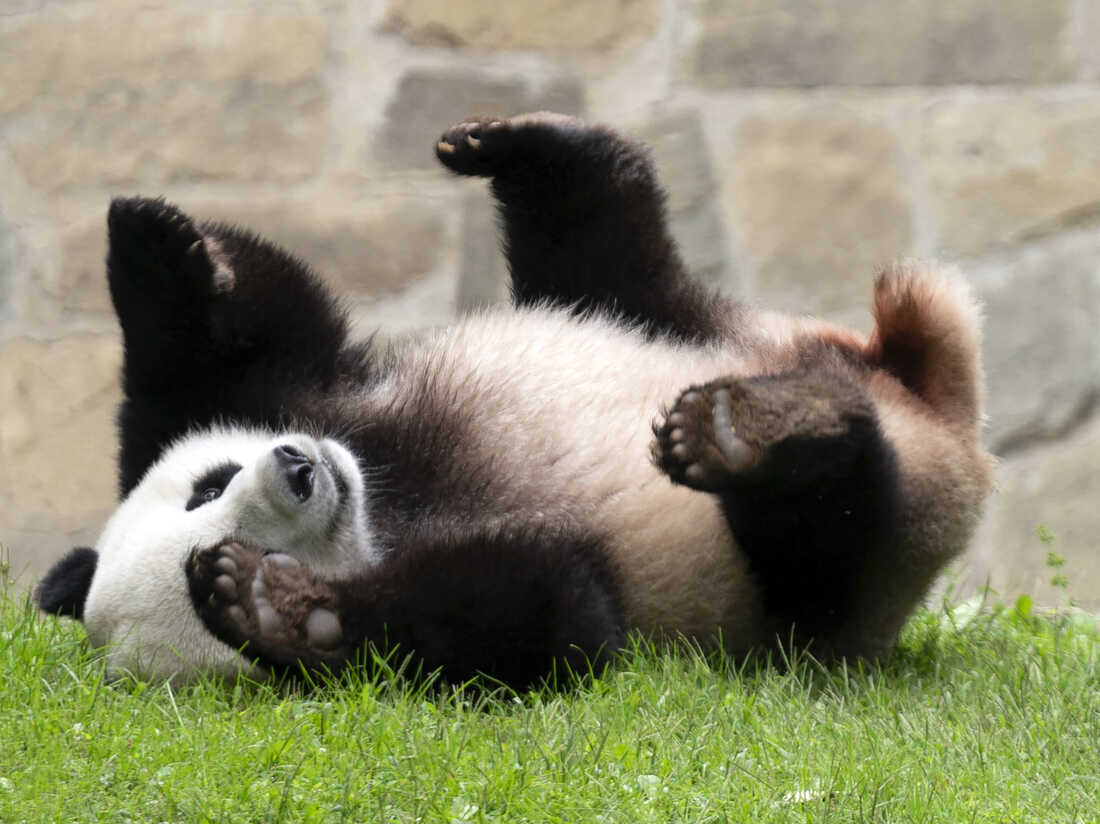

##### A. Requires pre-configuration for pyspark

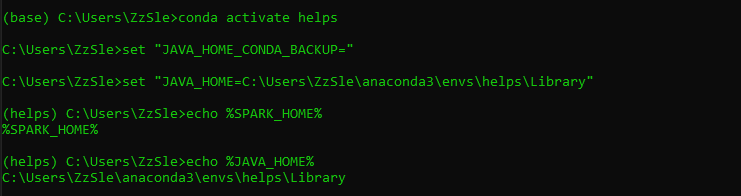

**pandas**
* simpler to set up with fewer dependencies, and minimal configurations
* pandas relies on libraries like numpy, etc, but these dependencies are automatically managed during installation
* light-weight

**pyspark**
* pyspark requires more libraries and dependencies - namely java, hadoop (depending on application), and spark, as it is the python API for apache spark
* when running pyspark in IDE, or similar, it is essential to properly configure environment variables for JAVA_HOME and SPARK_HOME, which is more time-consuming and resourceful in comparison to pandas

##### B. Computational Resources


Even with an increased the Java heap size by setting the spark.driver.memory configuration; executions were exited unexpectedly

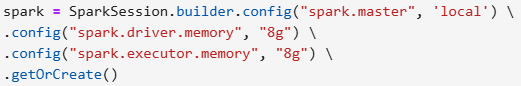

(Python worker exited unexpectedly) was encountered whilst querying with PySpark SQL in Jupyter on my local machine, which did not occur in Google Colab
* Likely due to hardware limitations or resource constraints on my personal laptop
* Using Google Colab provides access to Google's cloud infrastructure, which includes powerful CPUs, GPUs, and large amounts of RAM

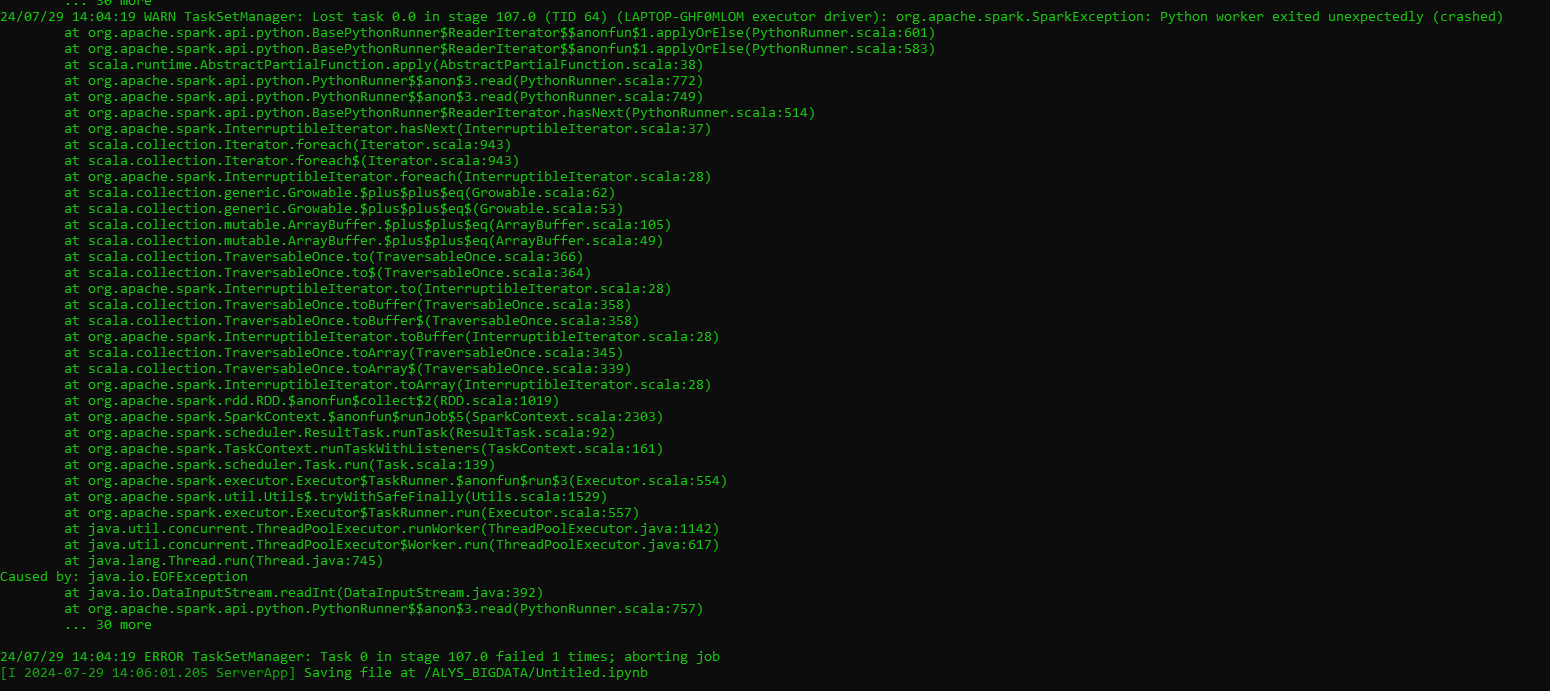

Error was not encountered whilst model training, only when querying with SQL, likely due to
* SQL querying in PySpark can require more memory than operations in pyspark.ml as SQL queries, especially complex ones involving joins, aggregations, and sorts, often require significant in-memory processing
* SQL queries can generate large intermediate results, which are temporarily stored in memory before the final result is produced; significantly increasing the memory usage

**pandas**
* light-weight and user-friendly
* operates in-memory on a single machine, making it simpler and less resource hungry as it utilizes local resources for data processing

**pyspark**
* pyspark typically requires more CPU and memory resources, due to its distributed nature - designed for distributed computing across a cluster of machines, resulting in higher overhead compared to pandas
* designed for handling large-scale datasets by leveraging distributed computing, requiring more infrastructure and resources


##### C. Efficiency

pandas for EDA and sklearn for model training takes about a couple seconds to minutes to execute whereas pyspark takes a considerably longer time to execute

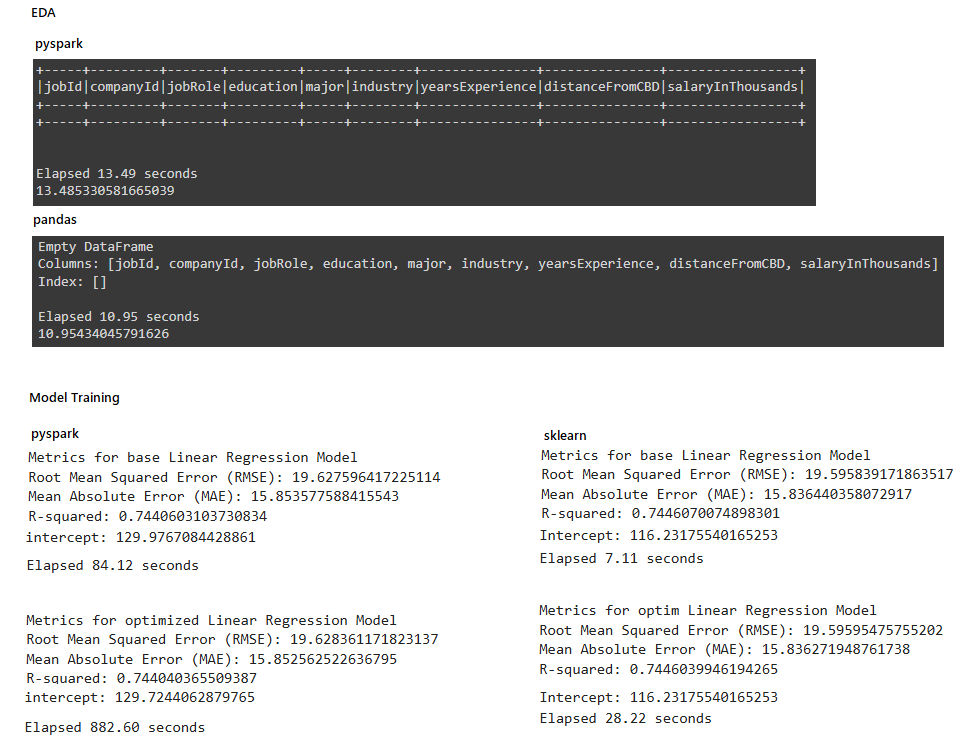

**pandas**
* faster for small to medium-sized datasets due to lower overhead and in-memory operations
* relies on in-memory of a single machine, making it efficient for operations that fit into the available RAM

**pyspark**
* overhead of starting and managing spark context and the distributed nature can make pyspark slower for small datasets
* better suited for handling large datasets as it can spill data to disk and optimize memory usage across the cluster

**sklearn**
* is optimized for small to medium-sized datasets that can fit into the memory of a single machine, making it efficient for operations that fit into the available RAM
* faster for small to medium-sized datasets due to lower overhead and in-memory operations
* lack of distributed overhead makes it ideal for tasks requiring low latency
* does offer some parallelism for tasks like cross-validation or training ensemble models

**pyspark.ml**
* better suited for handling large datasets as it can spill data to disk and optimize memory usage across the cluster
* slower for small datasets due to the overhead of setting up a distributed environment

##### D. Data Visualization

**pandas**
* more ideal library to work with visualization, and manipulation tasks
* integration with powerful graphing and visualization libraries such as seaborn, matplotlib, plotly, etc to enable seamless visualization directly with pandas dataframes
* visualization in graphical formats like barplots, line graphs, etc.
* helps in identifying trends, patterns, and outliers quickly, and makes it easier to compare different data series or categories; most importantly, provides a more intuitive, concise, and accessible way to grasp complex information

**pyspark**
* pyspark dataframes cannot be directly used for visualization, requires conversion of dataframes to pandas with .toPandas() before being able to visualize with graphs
* visualization in tabular format has benefits in providing exact values and detailed data in a structured format, and precise representation of numerical data without distortion
* however, doesn't easily show trends or patterns compared to graphical representations
* strengths of pyspark lie in distributed computing and handling large-scale data, usually the visualization section is integrated; designed for large-scale data processing

E. Learning Curve

**pandas and sklearn**
* user-friendly
* well-documented with a large community, allowing for easier referencing, and sourcing
* directly operates on in-memory dataframes

**pyspark**
* steeper learning curve due to the added complexity of distributed computing concepts and spark ecosystem
* not as extensive as pandas due to its more specialized use case
* works with distributed datasets (RDDs, DataFrames) which adds complexity

##### Summary

I would recommend that for personal projects,
* Solely pandas and sklearn would suffice due to the efficiency, and performance on a single machine
* Likely dealing with data in small to medium sizes and data that is less complex, which does not require pyspark's distributed nature

For organizational use, where there would be voluminous data and data streams involved,
* Availablility of suitable infrastructure to handle workloads
* pyspark.ml would be best suited for scenarios involving large-scale data processing, such as log analysis, recommendation systems, and real-time analytics
* Likely have specialized knowledge and expertise in dealing with Hadoop ecosystem and relational databases, overcoming the obstacle of learning curve
* Using an integration of pyspark with graphing libraries would help in presenting complex informaton in insightful, interactive, and aesthetically pleasing graphs and visualizations

# Recommended strategies for how a person can chart their career

A 30-year-old mid-careerist who recently got retrenched from the Web (AI,
Data Engineering) industry.

You are to provide the following insights based on
your findings and information available freely:


▪ Which industry he or she should move into?
▪ Give the reasons of why he or she should pursue that other than
salary.

▪ What are the skillsets needed for that industry?
▪ How can he or she obtain the skillset?


o The profile of the person is:


▪ Years of experience in the following:


• Web: 5
• Service: 1
• Education: 2


▪ Interest: Board games, fixing things.
▪ Yearly salary: $88,000

▪ Married with three cats, one goldfish and a chicken.


▪ Owns a house with a monthly mortgage of $2,500


▪ Monthly expenses: $4,200




---


He could move into the AUTO industry as
* Broad industry - branching out to mechanical, autonomous vehicles, and electric vehicles; depending on his passion and interests, he can align his AI and data background to gear towards autonomous vehicle development or, with his engineering background, gear towards traditional mechanical systems as technician
* He has interest in fixing things - the AUTO industry can be very hands-on, with many opportunities for someone who enjoys fixing and building
* May not the highest paying industry in comparison to WEB, however it is a promising industry with technological developments and breakthroughs - especially in autonomous vehicles
* He can leverage his specialized knowledge and expertise, coupled with continous learning - he will likely be able to gain invaluable experience and higher salary in AUTO industry
* Moreover, with his experience in EDUCATION and SERVICE, he would also be able to cater towards service-oriented or customer-facing responsibilities such as liasing with stakeholders, or he could excel in roles that involve educating customers or employees e.g. training programs for new automotive technologies
* Skills required
  * Technical skills
    * Programming and software development
    * Data analysis and machine learning
    * Automotive systems and electronics
    * Simulation and modelling
  * Domain knowledge
    * Vehicle dynamics and engineering
    * Safety and compliance
* He can gain the relevant skillsets by learning, and upskilling by taking up the relevant courses, he can take up apprenticeships to gain more exposure into this new industry, and self learning by being passionate

With his experience in AI and Data Engineering, coupled with experience in WEB,SERVICE and EDUCATION industries; offering him a unique blend of technical expertise, industry knowledge, and soft skills that are highly valuable currently in the job market.
* He is able to branch out to many other industries as his skills in AI and Data Engineering are highly sought after. He has the technical foundation needed to build, deploy, and optimize complex machine learning models, data pipelines, and intelligent systems. E.g. healthcare, financial tech, etc
* He can leverage his AI and Data Engineering skills to solve, analyze, and fix industry-specific problems - relating back to his interest of fixing things and board games
* As a 30 year old, he is still early in his career and has lots of room for exploration, and growth where he has the opportunity to explore different roles and industries without being too locked into a single career path, allowing him discover what he is most passionate about and where his strengths lie
* He can focus on acquiring a broad range of skills across multiple disciplines; making him a more versatile professional but also open up more opportunities as he advances in his career
* He can take advantage of his early career stage to invest in further education, certifications, and programs to continuously upskill himself
